###### Introduction

<b>Read this is you're new here</b>

This is a very confusing and all over the place document. Here's a few notes to make sure it ends up better than I originally planned. 

- <b>Independence:</b> Each section should be executable without the need for other sections, ideally. If you need a function, write it and put it in the function section. There, make the cell an 'initialization cell' (in <tt>View -> Initialization cells</tt>, then check the box)
- <b>Speed:</b> If the cell performs large data analysis (> 10 mins or something), try and save the data as well (if you're processing an array). Then, make the cell allow for loading that data, to save yourself time in the future.  
- <b>Save stuff: </b> I really wanted to have this as a workplace only, but it quickly grew much bigger than that. The problem is that the file becomes very very large, which makes this fairly slow. I'd say, try to save sections or parts of the code in individual python scripts, ready to be executed. 




# Intro

This is a quick script for the development of the spin dependent OAH analysis. 

## Imports And Constants

In [11]:
%matplotlib notebook
# plt.style.use('fivethirtyeight')  # pretty cool looking 

import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.widgets import Slider
from matplotlib import colors
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output
import scipy.odr as odr
import imageio
import gc
from matplotlib.widgets import EllipseSelector, RectangleSelector
from matplotlib.pyplot import cm
from scipy.special import eval_legendre
from scipy.optimize import curve_fit
import scipy.fftpack as fft
from matplotlib.colors import LogNorm
import csv
import cv2
import glob
import astropy.io.fits as pyfits
import argparse
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from PIL import Image


from OAH_refocus import *
import time
import sys
import argparse
import glob
import csv
import matplotlib
import math
from scipy.optimize import curve_fit
from fitfunctions import gaussmod, tfmod, bimodalmod, tfaxialmod, gaussmod_OAH, tfmod_OAH, bimodalmod_OAH
from scipy.ndimage.interpolation import rotate
from scipy.special import zeta

from IPython.display import clear_output

# Import own fit functions
import OAH_functions as f1
# import OAHDEV_functions as f2
from OAHDEV_functions import *
# from ..data_analysis import fits_analysis as fa


# Constants:
kB = 1.38064852E-23
m = 3.81923979E-26
hb = 1.0545718E-34
asc = 2.802642E-9
mu0 = 1E-50
e0 = 8.854187E-12
pix_size = 6.5E-6 / 2.63
# Light field properties
lamb0 = 589.1E-9  # Wavelength
k0 = 2 * np.pi / lamb0  # k-vector

<ipython-input-11-ea65ad09f9e7>:43: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [12]:
border_x = 5
border_z = 50

# Cutout
# ((xmin, xmax), (zmin, zmax)) = ((400, -200), (400, -200))
# ((xmin, xmax), (zmin, zmax)) = ((1000, 1400), (1000, 1400))
((xmin, xmax), (zmin, zmax)) = ((1, -1), (1, -1))
# ((xmin, xmax), (zmin, zmax)) = ((350, -350), (250, -250))

In [13]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Functions

### SOAH Functions

In [14]:
def OAH_full_process(date, shot, num, dz_focus, quad_cut, mask_w=0.51, multi_loop=0, peakswithfitting=False):
    print("Number = ", num)
    multi_loop  = 0
    el_x        = 10
    el_z        = 100
    edge_x      = 10
    edge_z      = 80
    e_w         = 0.1

    # ---------------------------------------------------------------------------------------------------
    # ------------------------------ OAH ENTIRE PROCESSING FUNCTION -------------------------------------
    # ---------------------------------------------------------------------------------------------------

    # ------------------------------------- OPEN FILES --------------------------------------------------
    atoms, flat, dark = openFiles(date, shot, num, multi_loop=multi_loop)

    # ----------------------------------- MASK THE EDGE -------------------------------------------------
    atoms      = f1.squaroid(atoms - dark, width=mask_w)
    flat       = f1.squaroid(flat - dark, width=mask_w)
#     atoms      = f1.ellipsoid(atoms - dark, width=mask_w, type="tukey")
#     flat       = f1.ellipsoid(flat - dark, width=mask_w, type="tukey")

    
    # ------------------------------------- TAKE FFT ----------------------------------------------------
    fft_atoms = np.fft.fft2(atoms)
    fft_flat = np.fft.fft2(flat)

    # ----------------------------------- TRIM THE EDGE -------------------------------------------------
    fft_atoms = fft_atoms[5:-5, 5:-5]
    fft_flat = fft_flat[5:-5, 5:-5]

    # ---------------------------- CUT QUADRANT AND MAKE ELLIPSOID  -------------------------------------
    quad1, q1peak  = f1.box_cutter_pad_ellips(fft_atoms, quad_cut, el_x, el_z, 
                                              edge_x=edge_x, edge_z=edge_z, e_w=e_w, 
                                              peakswithfitting=peakswithfitting)
    flatq1, f1peak = f1.box_cutter_pad_ellips(fft_flat,  quad_cut, indices=q1peak) # same indices as for quad
    quad1cut, flatq1cut = f1.sizecomp(quad1, flatq1)

    # ---------------------------------- SHIFT FFT TO CENTER  -------------------------------------------
    fft1 = np.fft.fftshift(quad1cut)
    flatfft1 = np.fft.fftshift(flatq1cut)
    
#     fft1 = quad1cut
#     flatfft1 = flatq1cut

    # -------------------------------------- REFOCUSING --------------------------------------------------
    fft_kx = np.fft.fftfreq(fft1.shape[1], d=pix_size)  # Discrete FFT Sample Frequency in x
    fft_ky = np.fft.fftfreq(fft1.shape[0], d=pix_size)  # Discrete FFT Sample Frequency in z
    fft_k2 = fft_kx[None, :] ** 2 + fft_ky[:, None] ** 2  # Discrete FFT Sample Frequency in main axes multiplied
    ly = 0  # .5E6#-3E6#.                                           # Adjusting the fft_ky array
    coma_y_arg = ly * fft_ky[:, None] * (3 * fft_k2 / k0 ** 2) / k0
    lin_y = np.exp(-1j * coma_y_arg)
    focus = np.exp(-1j * dz_focus * np.sqrt(k0 **2 - fft_k2))
    fft1 = fft1 * focus * lin_y
    flatfft1 = flatfft1 * focus * lin_y

    # ------------------------------------- INVERSE FFT -------------------------------------------------
    inv1 = np.fft.ifft2(fft1) / np.fft.ifft2(flatfft1)
    inv1 = inv1[border_x:-border_x, border_z:-border_z]

    # Get Phase
    ang1 = np.angle(inv1)
    ang1 = f1.unwrapper(ang1)

    # Get amp
    amp = np.abs(inv1)
    amp = np.log(amp**2)

    # Normalize
    normfactor = ang1.mean()
    ang1 = ang1 - normfactor
    ang1 = normalize(ang1)[0] 
    
    return atoms, flat, ang1, amp

In [15]:
def normalize(ang):
    """
    Returns the normalized image of the cloud - it fits each horizontal line of the image with a simple linear fit.
    Then it performs the vertical linear fit. This way, we get the background image, which we subtract from the actual image.
    It seems however that we might even have some quadratic, or maybe a gaussian would be easier? 
    """
    def linear_f(x, a, b):
        """ Faster, but does poor job. """
        return a * x + b
    
    def quadratic_f(x, a, b, c):
        """ Slower, but better equiped for normalizing"""
        return a * x**2 + b*x + c
    

    xdata = np.arange(0, len(ang[0]))
    ydata = np.arange(0, len(ang))
    arr_gradient = []
    arr_gradient_2 = []
    # Linear fit - horizontal gradient (for each line individualy)
    for i in range(ang.shape[0]):
        pars, cov = curve_fit(f=quadratic_f, xdata=xdata, ydata=ang[i], p0=[0, 0, 0])
        arr_line = quadratic_f(xdata, pars[0], pars[1], pars[2])
        arr_gradient.append(arr_line)
    lingrad = arr_gradient.copy()
    
    # Linear fit - vertical gradient (for each line individualy)
    arr_gradient = np.transpose(arr_gradient)  # Transpose
    for i in range(ang.shape[1]):
        pars, cov = curve_fit(f=quadratic_f, xdata=ydata, ydata=arr_gradient[i], p0=[0, 0, 0])
        arr_line = quadratic_f(ydata, pars[0], pars[1], pars[2])
        arr_gradient_2.append(arr_line)
    arr_gradient = np.transpose(arr_gradient_2)  # Transpose back
    
    ang = ang - arr_gradient
    return ang, arr_gradient, lingrad

In [16]:
def select_coords(pic, title_string=None):
    """ 
        A function to make a range selection a piece of cake. Plots the image (which is taken as an input).
        it is actually still a pain in the ass. It works in principle, but it's very annoying to implement it. 
    """
    def select_callback(eclick, erelease):
        """
        Callback for line selection.

        *eclick* and *erelease* are the press and release events.
        """
        global xtemp1, xtemp2, ytemp1, ytemp2
        xtemp1, ytemp1 = eclick.xdata, eclick.ydata
        xtemp2, ytemp2 = erelease.xdata, erelease.ydata
        title.set_text("Coordinates Recorded: \n X = {:} - {:}, Y = {:} - {:} \nPress Enter to save.".format(round(xtemp1),round(xtemp2),round(ytemp1),round(ytemp2)))
        fig.canvas.draw_idle()

    def toggle_selector(event):
        print('Key pressed.')
        if event.key == 't':
            for selector in selectors:
                name = type(selector).__name__
                if selector.active:
                    print(f'{name} deactivated.')
                    selector.set_active(False)
                else:
                    print(f'{name} activated.')
                    selector.set_active(True)
        elif event.key == 'enter':
            # print("Enter pressed")
            plt.close()
            t_var = True
    
    t_var = False
    fig, ax = plt.subplots()
    ax.imshow(pic)
    

    N = 100000  # If N is large one can see improvement by using blitting.
    x = np.linspace(0, 10, N)

    selectors = []
    for selector_class in [RectangleSelector]:
        selectors.append(selector_class(
            ax, select_callback,
            useblit=True,
            button=[1, 3],  # disable middle button
            minspanx=5, minspany=5,
            spancoords='pixels',
            interactive=True))
        fig.canvas.mpl_connect('key_press_event', toggle_selector)

    if title_string is None:
        title = ax.set_title("Make a selection and \n press Enter to save the coordinates.")
    else: 
        title = ax.set_title("{:} and \n press Enter to save the coordinates.".format(title_string))

    fig.canvas.draw_idle()

    return xtemp1, xtemp2, ytemp1, ytemp2

        

def wrapper(pic):
    xtemp1, xtemp2, ytemp1, ytemp2 = select_coords(pic)
    return xtemp1, xtemp2, ytemp1, ytemp2

In [17]:
# Initial values
initial_fit_vals = {
    "offset": 0.,
    "amp_ov": 1.,
    "ang": 0,
    "center": (50, 850),
    "tfa": 1,
    "tfw": (20, 50),
    "ga": 1,
    "gw": (200, 200),
    "j_guess": 40 ,
    "axamp": 1,
    "x_shift": 0.0,
    "squeeze_par": 1.0,
}

In [18]:
def fitting(pic, mode, init_guess=initial_fit_vals, normalize=False, invert=False, OAH=False):
    
    # Initial values
    offset = init_guess["offset"]
    amp_ov = init_guess["amp_ov"]
    ang = init_guess["ang"]
    center = init_guess["center"]
    tfa = init_guess["tfa"]
    tfw = init_guess["tfw"]    
    ga = init_guess["ga"]
    gw = init_guess["gw"]    
    j_guess = init_guess["j_guess"]
    axamp = init_guess["axamp"]    
    x_shift = init_guess["x_shift"]
    squeeze_par = init_guess["squeeze_par"]
    
#     print(init_guess)
    
    
    # Normalize everything between 1 and 0
    if normalize:
#         pic = pic[10:-10, 10:-10]
        pic = pic + abs(pic.min()) + 0.00001
        avg_bg = pic.mean()
        pic = pic/avg_bg

    if invert:
        # Normalize such that the background is at 1, the peak is at zero.         
        pic= - pic + 0.5

        
    mask = pic == 0
    pic = np.ma.array(pic, mask=mask)
    # Generate empty arrays of the pic size which we will feed into the fitting procedure.
    # Create a 'fitvars' array of x and y coordinates
    x = np.arange(pic.shape[0])
    y = np.arange(pic.shape[1])
    xv, yv = np.meshgrid(x, y, indexing='ij')
    fitvars = np.array([xv, yv]).reshape(2, -1)

    xbin = 1
    zbin = 1

    # Constants
    pixelsize = 2.47148288973384e-06 
    kB = 1.38064852E-23
    m = 3.81923979E-26
    hb = 1.0545718E-34
    asc = 2.802642E-9
    mu0 = 1e-50
    e0 = 8.854187E-12
    fx = 115
    fz = 15
    wavelength = 589e-9
    detuning = 0
    prefactor = float((1 + 4 * detuning ** 2) * 2 * np.pi / (3 * (wavelength ** 2)) * 18. / 5.)

    xmin, xmax, zmin, zmax = 0, 0, 0, 0
    
    par_names = ['offset', 'ampl', 'ang', 'xmid', 'ymid', 'tfamp', 'tfxw', 'tfyw', 'gamp', 'gxw', 'gyw']
    bin_scaling = np.array([1., 1., 1., xbin, zbin, 1., xbin, zbin, 1., xbin, zbin])
    rng_offset = np.array([0., 0., 0., xmin, zmin, 0., 0., 0., 0., 0., 0.])
    init_guess = np.array([offset, amp_ov, ang, center[0], center[1], tfa, tfw[0], tfw[1], ga, gw[0], gw[1]])
    to_physical = np.array([1., 1., 1., pixelsize, pixelsize, prefactor, pixelsize, pixelsize, prefactor, pixelsize, pixelsize])
    corr_guess = (init_guess - rng_offset) / bin_scaling

    if OAH:
        if mode == "gauss":
            corr_guess = np.append(corr_guess[:5], corr_guess[-3:])
            bin_scaling = np.append(bin_scaling[:5], bin_scaling[-3:])
            rng_offset = np.append(rng_offset[:5], rng_offset[-3:])
            par_names = np.append(par_names[:5], par_names[-3:])
            to_physical = np.append(to_physical[:5], to_physical[-3:])
            odrmodel = odr.Model(gaussmod_OAH)  # Store information for the gaussian fitting model

        if mode == "doubletf":
            corr_guess = np.append(corr_guess[:8], [center2[0], center2[1], tfa2, tfw2[0], tfw2[1]])
            bin_scaling = np.append(bin_scaling[:8], bin_scaling[3:8])
            rng_offset = np.append(rng_offset[:8], rng_offset[3:8])
            par_names = np.append(par_names[:8], par_names[3:8])
            to_physical = np.append(to_physical[:8], to_physical[3:8])
            odrmodel = odr.Model(double_tf_OAH)  # Store information for the gaussian fitting model

            
        if mode == "tf":
            corr_guess = corr_guess[:8]
            bin_scaling = bin_scaling[:8]
            rng_offset = rng_offset[:8]
            par_names = par_names[:8]
            to_physical = to_physical[:8]
            odrmodel = odr.Model(tfmod_OAH)  # Store information for the tf fitting model

        if mode == "bimodal":
            odrmodel = odr.Model(bimodalmod_OAH)  # Store information for the bimodal fitting model
            
        
    else: 
        if mode == "gauss":
            corr_guess = np.append(corr_guess[:5], corr_guess[-3:])
            bin_scaling = np.append(bin_scaling[:5], bin_scaling[-3:])
            rng_offset = np.append(rng_offset[:5], rng_offset[-3:])
            par_names = np.append(par_names[:5], par_names[-3:])
            to_physical = np.append(to_physical[:5], to_physical[-3:])
            odrmodel = odr.Model(gaussmod)  # Store information for the gaussian fitting model

        if mode == "tf":
            corr_guess = corr_guess[:8]
            bin_scaling = bin_scaling[:8]
            rng_offset = rng_offset[:8]
            par_names = par_names[:8]
            to_physical = to_physical[:8]
            odrmodel = odr.Model(tfmod)  # Store information for the tf fitting model

        if mode == "bimodal":
            odrmodel = odr.Model(bimodalmod)  # Store information for the bimodal fitting model

        if mode == "timecrystal":
            corr_guess = corr_guess[:8]
            corr_guess = np.append(corr_guess, j_guess)
            corr_guess = np.append(corr_guess, axamp)
            corr_guess = np.append(corr_guess, x_shift)
            corr_guess = np.append(corr_guess, squeeze_par)
            bin_scaling = bin_scaling[:8]
            bin_scaling = np.append(bin_scaling, 1.)
            bin_scaling = np.append(bin_scaling, 1.)
            bin_scaling = np.append(bin_scaling, 1.)
            bin_scaling = np.append(bin_scaling, 1.)
            rng_offset = rng_offset[:8]
            rng_offset = np.append(rng_offset, 0)
            rng_offset = np.append(rng_offset, 0)
            rng_offset = np.append(rng_offset, 0)
            rng_offset = np.append(rng_offset, 0)
            par_names = par_names[:8]
            par_names = np.append(par_names, "j parameter")
            par_names = np.append(par_names, "axamp")
            par_names = np.append(par_names, "x_shift")
            par_names = np.append(par_names, "squeeze_par")
            to_physical = to_physical[:8]
            to_physical = np.append(to_physical, 1.)
            to_physical = np.append(to_physical, 1.)
            to_physical = np.append(to_physical, 1.)
            to_physical = np.append(to_physical, 1.)
            odrmodel = odr.Model(tfaxialmod)
        
       
    print(corr_guess)
    # Run the ODR Fit procedure.
    odrdata = odr.Data(fitvars[:, ~pic.mask.flatten()], pic.flatten()[~pic.mask.flatten()])
    odrobj = odr.ODR(odrdata, odrmodel, beta0=corr_guess)
    odrobj.set_job(2)  # Ordinary least-sqaures fitting
    odrout = odrobj.run()
#     odrout.pprint()


    if OAH:
        # This sets the angle to be correct wrt x and y.
        if np.abs(odrout.beta[2] % np.pi) > np.pi / 4.:
            odrout.beta[2] = odrout.beta[2] - np.pi / 2.
            print("Performing xy swap due to angle.")
            if mode == "bimodal":
                tmp_tfx = odrout.beta[6]
                tmp_gx = odrout.beta[-2]
                odrout.beta[6] = odrout.beta[7]
                odrout.beta[7] = tmp_tfx
                odrout.beta[-2] = odrout.beta[-1]
                odrout.beta[-1] = tmp_gx
            else:
                tmp = odrout.beta[6]
                odrout.beta[6] = odrout.beta[7]
                odrout.beta[7] = tmp

        if mode == "gauss":
            fitresult = gaussmod_OAH(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = gaussmod_OAH(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []
        
        if mode == "doubletf":
            fitresult = double_tf_OAH(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = double_tf_OAH(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []

        if mode == "tf":
            fitresult = tfmod_OAH(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = tfmod_OAH(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []

        if mode == "bimodal":
            fitresult = bimodalmod_OAH(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresulttf = tfmod_OAH(odrout.beta[:8], fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = gaussmod_OAH(np.append(odrout.beta[:5], odrout.beta[-3:]), fitvars).reshape(pic.shape[0],pic.shape[1])
            fitguess = bimodalmod_OAH(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
        
    else:
        # This sets the angle to be correct wrt x and y.
        if np.abs(odrout.beta[2] % np.pi) > np.pi / 4.:
            odrout.beta[2] = odrout.beta[2] - np.pi / 2.
            print("Performing xy swap due to angle.")
            if mode == "bimodal":
                tmp_tfx = odrout.beta[6]
                tmp_gx = odrout.beta[-2]
                odrout.beta[6] = odrout.beta[7]
                odrout.beta[7] = tmp_tfx
                odrout.beta[-2] = odrout.beta[-1]
                odrout.beta[-1] = tmp_gx
            else:
                tmp = odrout.beta[6]
                odrout.beta[6] = odrout.beta[7]
                odrout.beta[7] = tmp

        if mode == "gauss":
            fitresult = gaussmod(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = gaussmod(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []
            
        if mode == "tf":
            fitresult = tfmod(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = tfmod(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []

        if mode == "bimodal":
            fitresult = bimodalmod(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresulttf = tfmod(odrout.beta[:8], fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = gaussmod(np.append(odrout.beta[:5], odrout.beta[-3:]), fitvars).reshape(pic.shape[0],pic.shape[1])
            fitguess = bimodalmod(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])

        if mode == "timecrystal":
            fitresult = tfaxialmod(odrout.beta, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitguess = tfaxialmod(corr_guess, fitvars).reshape(pic.shape[0], pic.shape[1])
            fitresultgauss = []
            fitresulttf = []
        
#     print("The shape of the pic file: \n{:}\n".format(pic.shape))
#     print("The guess parameters: \n{:}\n".format(corr_guess))
#     print("Odrout: \n{:}\n".format(odrout.beta))

    # As the entire output, except for the angle and the offset, has to be positive,
    # we take the absolute value of the entire list, then put the angle and offset back in.
    offset_temp = odrout.beta[0]
    ang_temp = odrout.beta[2]
    odrout.beta = np.abs(odrout.beta)
    odrout.beta[0] = offset_temp
    odrout.beta[2] = ang_temp % np.pi
    
    # Converts the fit results to absolute pixel values in the unbinned image.
    fit_results = odrout.beta * bin_scaling + rng_offset
    phys_results = fit_results * to_physical

    tof = 0
    ncount = - np.log(pic.flatten()).sum() * prefactor * pixelsize ** 2 * xbin * zbin
    ntherm = 0
    ntf = 0
    tx = 0
    tz = 0
    mux = 0
    muz = 0
    mun = 0

    if mode == "gauss":
        ntherm = 2 * np.pi * phys_results[5] * phys_results[6] * phys_results[7]
        tx = 1 / kB * m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        tz = 1 / kB * m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mux = m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        muz = m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mun = 1.47708846953 * np.power(
            ntf * asc / (np.sqrt(hb / (m * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)))),
            2. / 5.) * hb * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)
    if mode == "tf":
        ntf = 2. * np.pi / 5. * phys_results[5] * phys_results[6] * phys_results[7]  # 2/5 = 8/15 / (4/3)
        tx = 1 / kB * m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        tz = 1 / kB * m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mux = m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        muz = m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mun = 1.47708846953 * np.power(
            ntf * asc / (np.sqrt(hb / (m * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)))),
            2. / 5.) * hb * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)
    if mode == "timecrystal":
        ntf = 2. * np.pi / 5. * phys_results[5] * phys_results[6] * phys_results[7]  # 2/5 = 8/15 / (4/3)
        tx = 1 / kB * m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        tz = 1 / kB * m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mux = m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        muz = m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mun = 1.47708846953 * np.power(
            ntf * asc / (np.sqrt(hb / (m * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)))),
            2. / 5.) * hb * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)
    if mode == "bimodal":
        ntf = 2. * np.pi / 5. * phys_results[5] * phys_results[6] * phys_results[7]
        ntherm = 2 * np.pi * phys_results[8] * phys_results[9] * phys_results[10]
        tx = 1 / kB * m / 1 * (fx * np.pi * 2 * phys_results[9]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        tz = 1 / kB * m / 1 * (fz * np.pi * 2 * phys_results[10]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mux = m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2)
        muz = m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2)
        mun = 1.47708846953 * np.power(
            ntf * asc / (np.sqrt(hb / (m * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)))),
            2. / 5.) * hb * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)

    ntotal = ntherm + ntf

    fitted_vars = (ncount, ntherm, ntf, tx, tz, mux, muz, mun)
    
    return pic, fitresult, fitguess, fitresultgauss, fitresulttf, fitted_vars, odrout



In [19]:
# Fit and Rotate
###### ------------ ROTATE ---------------- 
# Since the condensates are pretty thin in the ODT, let's rotate them as well, so a linecut will be nicer. 
# Additionally, we will also be able to compare the fits themself. Fitting with TF model. 

def rotateFunction(ang1, ang2, mode="tf"):
    """
        We do it together for both, so that we also make sure that they are of
        the same size. Which we need for fitting. 
    """
    tfw = (ang1.shape[0]//5, ang1.shape[1]//2)
    gw = (ang1.shape[0]//5, ang1.shape[1]//2)
    fit_1 = fitting(ang1, init_guess=initial_g_1, mode="tf", OAH=True)
    fit_2 = fitting(ang2, init_guess=initial_g_2, mode="tf", OAH=True)
    # fit: pic, fitresult, fitguess, fitresultgauss, fitresulttf, fitted_vars, odrout
    clear_output()

    print(f"Angle 1 = {fit_1[6].beta[2]*(180/np.pi)}")
    print(f"Angle 2 = {fit_2[6].beta[2]*(180/np.pi)}")
    print(fit_1[6].beta)
    
    # Rotating the image and also the fitresult
#     ang1_rot = rotate(fit_1[0], (fit_1[6].beta[2]*(180/np.pi)), mode='reflect')
#     ang2_rot = rotate(fit_2[0], (fit_2[6].beta[2]*(180/np.pi)), mode='reflect')
    ang1_rot = rotate(ang1, (fit_1[6].beta[2]*(180/np.pi)), mode='reflect')
    ang2_rot = rotate(ang2, (fit_2[6].beta[2]*(180/np.pi)), mode='reflect')
    fitresult1_rot = rotate(fit_1[1], (fit_1[6].beta[2]*(180/np.pi)), mode='reflect')
    fitresult2_rot = rotate(fit_2[1], (fit_2[6].beta[2]*(180/np.pi)), mode='reflect')

    # If 90 degrees off: 
    if ang1_rot.shape[0] > ang1_rot.shape[1]:
        ang1_rot = np.transpose(np.transpose(np.transpose(ang1_rot)))
        fitresult1_rot = np.transpose(np.transpose(np.transpose(fitresult1_rot)))

    if ang2_rot.shape[0] > ang2_rot.shape[1]:
        ang2_rot = np.transpose(np.transpose(np.transpose(ang2_rot)))
        fitresult2_rot = np.transpose(np.transpose(np.transpose(fitresult2_rot)))

    # Also, let's minus the offset on all of them:
    ang1_rot -= fit_1[6].beta[0]
    ang2_rot -= fit_2[6].beta[0]

    fitresult1_rot -= fit_1[6].beta[0]
    fitresult2_rot -= fit_2[6].beta[0]
    
    
    # make sure ang1_rot and ang2_rot are the same size:
    xedge = min(ang1_rot.shape[0], ang2_rot.shape[0])
    yedge = min(ang1_rot.shape[1], ang2_rot.shape[1])
    ang1_rot = ang1_rot[0:xedge, 0:yedge]
    ang2_rot = ang2_rot[0:xedge, 0:yedge]
    fitresult1_rot = fitresult1_rot[0:xedge, 0:yedge]
    fitresult2_rot = fitresult2_rot[0:xedge, 0:yedge]
    
    
#     # After subtracting the background, fit with the double tf. 
#     fit_1 = fitting(ang1_rot, mode="doubletf", OAH=True)
#     fit_2 = fitting(ang2_rot, mode="doubletf", OAH=True)
#     # fit: pic, fitresult, fitguess, fitresultgauss, fitresulttf, fitted_vars, odrout
#     clear_output()
    
    return [ang1_rot, ang2_rot, fitresult1_rot, fitresult2_rot, fit_1, fit_2]




In [20]:
def getCoords(date, shot):
    """ 
    Call this to open an image, and get coordinates. Coordinates 
    are automaticall saved into a global 'cut' variable
    """
    input_folder = f'/storage/data/{date}/{str(shot).zfill(4)}/'
    
    # Check for refocused one and display the 0th one
    files = []
    for file in os.listdir(input_folder):
        if file.startswith("pics"):
            files.append(file)

    if len(files) == 0:
        atom = pyfits.open(input_folder + '0.fits')[0].data.astype(float)[0]  # .mean(axis=0)
        flat = pyfits.open(input_folder + '1.fits')[0].data.astype(float)[0]  # .mean(axis=0)
        dark = pyfits.open(input_folder + '2.fits')[0].data.astype(float).mean(axis=0)
        pic = (atom - dark) / (flat - dark)
        vmin = 0
        vmax = 1.3

    else:
        pics = pyfits.open(input_folder + files[0])[0].data.astype(float)[0]  # .mean(axis=0)
        pic = pics
        vmin = -3 #pic.min()
        vmax = 3 #pic.max()


    def select_callback(eclick, erelease):
        """
        Callback for line selection.
        *eclick* and *erelease* are the press and release events.
        """
        global x1, x2, y1, y2
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        title.set_text("Coordinates Recorded: \n X = {:} - {:}, Y = {:} - {:} \nPress Enter to save.".format(round(x1), round(x2), round(y1), round(y2)))
        fig.canvas.draw_idle()


    def toggle_selector(event):
        print('Key pressed.')
        if event.key == 't':
            for selector in selectors:
                name = type(selector).__name__
                if selector.active:
                    print(f'{name} deactivated.')
                    selector.set_active(False)
                else:
                    print(f'{name} activated.')
                    selector.set_active(True)
        elif event.key == 'enter':
            global cut, lc
            cut = [int(y1), int(y2), int(x1), int(x2)]
            lc = int((y2 - y1)//2)
            title.set_text(f"{cut=} SAVED in 'cut'")
            fig.canvas.draw_idle()
            plt.close()
            clear_output()


    fig, ax = plt.subplots()
    ax.imshow(pic, vmin=vmin, vmax=vmax, interpolation='none', origin="lower")
    N = 100000  # If N is large one can see improvement by using blitting.
    x = np.linspace(0, 10, N)

    selectors = []
    for selector_class in [RectangleSelector]:
        selectors.append(selector_class(
            ax, select_callback,
            useblit=True,
            button=[1, 3],  # disable middle button
            minspanx=5, minspany=5,
            spancoords='pixels',
            interactive=True))
        fig.canvas.mpl_connect('key_press_event', toggle_selector)

    title = ax.set_title("Make a selection and \n press Enter to save the coordinates.")
    fig.canvas.draw_idle()
    plt.show()
    

## FFT Processing Example

In [651]:
# Both beams OAH in ODT 
date = 20230425
shot = 137
num = 0
dz_focus = 0.000

In [652]:
atoms_q1, flat_q1, dark_q1, fft_atoms_q1, fft_flat_q1, ang1_q1, amp_q1 = fft_analysis(date, shot, num, dz_focus, quad_cut="quad1", multi_loop=0, el_x=10, el_z=100, edge_x=10, edge_z=80, e_w=0.1)
atoms_q2, flat_q2, dark_q2, fft_atoms_q2, fft_flat_q2, ang1_q2, amp_q2 = fft_analysis(date, shot, num, dz_focus, quad_cut="quad2", multi_loop=0, el_x=10, el_z=100, edge_x=10, edge_z=80, e_w=0.1)

Indices provided: 
(2148, 2548) (2148, 2548)
Indices provided: 
(2148, 2548) (2148, 2548)


In [653]:
ang1 = ang1_q1[1070:1160, 1006:1200]
ang2 = ang1_q2[1070:1160, 1006:1200]
x = np.linspace(0, len(ang1[0]), len(ang1[0]))

fig, ax = plt.subplots(3, 2)
fig.suptitle(f"{date}-{shot}")
ax[0][0].set_title("Quad 1")
ax[0][1].set_title("Quad 2")

ax[0][0].imshow(ang1, cmap='afmhot_r', interpolation='none', origin="lower", vmin=-0.5, vmax=4, aspect='auto')
ax[0][1].imshow(ang2, cmap='afmhot_r', interpolation='none', origin="lower", vmin=-0.5, vmax=4, aspect='auto')

ax[0][0].axhline(y=40, alpha=0.2, c='C0')
ax[0][0].axhline(y=48, alpha=0.2, c='C0')
ax[0][1].axhline(y=40, alpha=0.2, c='C1')
ax[0][1].axhline(y=48, alpha=0.2, c='C1')

ax[0][0].axvline(x=62, alpha=0.2, c='C0')
ax[0][0].axvline(x=132, alpha=0.2, c='C0')
ax[0][1].axvline(x=62, alpha=0.2, c='C1')
ax[0][1].axvline(x=132, alpha=0.2, c='C1')


intg_ang1 = ang1[40:48].sum(axis=0)/8
intg_ang2 = ang2[40:48].sum(axis=0)/8
ax[1][0].plot(intg_ang1, c='C0')
ax[1][1].plot(intg_ang2, c='C1')
ax[1][0].fill_between(x, -0.20, intg_ang1, color='C0', alpha=0.3)
ax[1][1].fill_between(x, -0.20, intg_ang2, color='C1', alpha=0.3)

intg_ang1_v = ang1[:, 62:132].sum(axis=1)/70
intg_ang2_v = ang2[:, 62:132].sum(axis=1)/70
ax[2][0].plot(range(90), intg_ang1_v, c='C0')
ax[2][1].plot(range(90), intg_ang2_v, c='C1')
ax[2][0].fill_between(range(90), intg_ang1_v, color='C0', alpha=0.3)
ax[2][1].fill_between(range(90), intg_ang2_v, color='C1', alpha=0.3)

ax[1][0].set_ylabel("Horizontal Avg")
ax[2][0].set_ylabel("Vertical Avg")



for b in ax:
    for a in b:
        a.set_xticks([])
        a.set_yticks([])
        
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [654]:
intg_ang1 = ang1[40:48].sum(axis=0)/8
intg_ang2 = ang2[40:48].sum(axis=0)/8

fig, ax = plt.subplots(2,1)
ax[0].plot(intg_ang1, c='C0')
ax[0].plot(intg_ang2, c='C1')
ax[0].fill_between(x, -0.20, intg_ang1, color='C0', alpha=0.3)
ax[0].fill_between(x, -0.20, intg_ang2, color='C1', alpha=0.3)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Horizontal Avg")

ax[1].plot(intg_ang1_v, c='C0')
ax[1].plot(intg_ang2_v, c='C1')
ax[1].fill_between(range(90), -0.20, intg_ang1_v, color='C0', alpha=0.3)
ax[1].fill_between(range(90), -0.20, intg_ang2_v, color='C1', alpha=0.3)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Vertical Avg")


plt.show()


<IPython.core.display.Javascript object>

# Optical Dipole Trap 

## Temperature depth of ODT 

Calculating the temperature depth of the ODT trap. Depends on the atomic resonance frequency, natural linewidth of the transition, the frequency of the light field, and the intensity of the light field. 

$$ T = \dfrac{U_0}{k_B} = \frac{3\pi c^2}{2 \omega_0^3} \Big( \frac{\Gamma}{\omega_0 - \omega} +  \frac{\Gamma}{\omega_0 + \omega} \Big) I(r,z), $$ 

with intensity given by 


$$ I(r,z) = \frac{2P}{\pi w_0^2}. $$

In [255]:
def temp_ODT(waist, P):
    # Constants
    w_0 = 508.8487162e12 * 2 * np.pi
    Gamma = 9.746e6 * 2 * np.pi
    c = 299792458
    w = c / 1070e-9
    return (6 * Gamma * w_0 * P * c**2)/(w_0**3 * waist**2 * (w_0**2 - w**2)) / kB



In [242]:
"\u03BC"

'μ'

In [253]:
def trap_rho(waist, P):
    # Constants
    w_0 = 508.8487162e12 * 2 * np.pi
    Gamma = 9.746e6 * 2 * np.pi
    c = 299792458
    w = c / 1070e-9
    m = 3.81923979e-26
    U0 = (6 * Gamma * w_0 * P * c**2)/(w_0**3 * waist**2 * (w_0**2 - w**2))
    return np.sqrt(4*U0/(m*waist**2))

def trap_z(waist, P):
    # Constants
    w_0 = 508.8487162e12 * 2 * np.pi
    Gamma = 9.746e6 * 2 * np.pi
    c = 299792458
    wavelength = 1070e-9
    w = c / wavelength
    m = 3.81923979e-26
    U0 = (6 * Gamma * w_0 * P * c**2)/(w_0**3 * waist**2 * (w_0**2 - w**2))
    zR = np.pi*waist**2/wavelength
    
#     return np.sqrt(2*U0/(m*waist**2/wavelength))
    return np.sqrt(2*U0/(m*zR**2))


def summary_ODT(waist, P):
    """ waist in meters, power in watts """
    
    temp = temp_ODT(waist, P)
    w_rho = trap_rho(waist, P)
    w_z = trap_z(waist, P)

    print(f"P = {P} W, w_0 = {waist*1e6} \u03BCm: ")
    print("--------------------------------------")
    print(f"{'T':<15} = {round(temp*1e6, 4)} \u03BCK")
    print(f"{'w_rho':<15} = {round(w_rho /(2*np.pi), 2)} 2\u03C0 Hz")
    print(f"{'w_z':<15} = {round(w_z /(2*np.pi), 2)} 2\u03C0 Hz")
    print("--------------------------------------")
    print()

In [256]:
summary_ODT(15e-6, 0.16)
summary_ODT(15e-6, 0.3)

P = 0.16 W, w_0 = 15.0 μm: 
--------------------------------------
T               = 16.4031 μK
w_rho           = 1634.09 2π Hz
w_z             = 26.24 2π Hz
--------------------------------------

P = 0.3 W, w_0 = 15.0 μm: 
--------------------------------------
T               = 30.7559 μK
w_rho           = 2237.57 2π Hz
w_z             = 35.93 2π Hz
--------------------------------------



## Potential and Force of ODT

In [644]:
def potential_ODT(waist, P):
    # Constants
    w_0 = 508.8487162e12 * 2 * np.pi
    Gamma = 9.746e6 * 2 * np.pi
    c = 299792458
    w = c / 1070e-9
    return (6 * Gamma * w_0 * P * c**2)/(w_0**3 * waist**2 * (w_0**2 - w**2))
    
potential_ODT(waist=11e-6, P=0.23)

6.053621415677109e-28

## Analyse velocities

In [155]:
date = 20241206 #20230515 #20230420
num = 0

In [156]:
xbin = 4
zbin = 4

# Initial values
initial_fit_vals = {
    "offset": 0.,
    "amp_ov": 1.,
    "ang": 0,
    "center": (267, 425),
    "tfa": 1,
    "tfw": (5, 40),
    "ga": 1,
    "gw": (20, 80),
    "j_guess": 40 ,
    "axamp": 1,
    "x_shift": 0.0,
    "squeeze_par": 1.0,
}

In [158]:
odrout_all = []
tof_all = []

### MODE 
mode = "tf"


pathdir = "/home/bec_lab/Desktop/imgs/ODT/{:}/{:}/".format(date, mode)
if not os.path.exists(pathdir):
    # If it doesn't exist, create it
    os.makedirs(pathdir) 
    
itter = 0    
for shot in range(83, 115):
    if shot not in [94, 95]:
        # for shot in range(83, 115) if shot not in [94, 95]: #range(21, 47): #range(113, 176):
        print("Processing:", shot)
        atoms, flat, dark = openFiles(date, shot, num, multi_loop=0)
        tof_ir = get_parameter(date, shot, "tof")
        pic = (atoms - dark) / (flat - dark)
        pic[pic < 0.0001] = 0.0001
        mask = flat - dark < 25.
        pic = np.ma.array(pic, mask=mask)

        # Bin 
        if pic.shape[0] % xbin != 0:
            pic = pic[:-(pic.shape[0] % xbin), :]
        if pic.shape[1] % zbin != 0:
            pic = pic[:, :-(pic.shape[1] % zbin)]
        pic = pic.reshape(pic.shape[0] // xbin, xbin, pic.shape[1] // zbin, zbin).mean(axis=3).mean(axis=1)

        if itter > 0:  # should if if a previous fit was successful, somehow? 
            initial_fit_vals['offset'] = odrout.beta[0]
            initial_fit_vals['amp_ov'] = odrout.beta[1]
            initial_fit_vals['ang'] = odrout.beta[2]
            initial_fit_vals['center'] = (odrout.beta[3], odrout.beta[4]) 
            initial_fit_vals['tfa'] = odrout.beta[5]
            initial_fit_vals['tfw'] = (odrout.beta[6], odrout.beta[7])
            
#             initial_fit_vals['ga'] = odrout.beta[8]
#             initial_fit_vals['gw'] = (odrout.beta[9], odrout.beta[10])

        # Let's fit
        pic, fitresult, fitguess, fitresultgauss, fitresulttf, fitted_vars, odrout = fitting(pic, mode, init_guess=initial_fit_vals)

        # Append all 
        odrout_all.append(odrout.beta)
        tof_all.append(tof_ir)

        fig, ax = plt.subplots(1, 3, figsize=(12, 8))
        ax[0].imshow(pic, cmap="afmhot_r", vmin=0, vmax=1.3, interpolation='none', origin="lower", aspect=1)
        ax[1].imshow(fitresult, cmap="afmhot_r", vmin=0, vmax=1.3, interpolation='none', origin="lower", aspect=1)
        ax[2].imshow(fitguess, cmap="afmhot_r", vmin=0, vmax=1.3, interpolation='none', origin="lower", aspect=1)
        fig.suptitle("TOF = {:}".format(tof_ir))
        plt.savefig("/home/bec_lab/Desktop/imgs/ODT/{:}/{:}/tof_{:}.png".format(date, mode, str(int(tof_ir*1000)).zfill(9)))
        plt.close()
        clear_output()
        itter += 1 

    
# Save processed lengths
np.save(pathdir + "odrout", odrout_all)
np.save("/home/bec_lab/Desktop/imgs/ODT/{:}/tofall".format(date), tof_all)

In [160]:
# odrout_gauss = np.load("/home/bec_lab/Desktop/imgs/ODT/{:}/{:}/odrout.npy".format(date, "gauss"))
odrout_tf = np.load("/home/bec_lab/Desktop/imgs/ODT/{:}/{:}/odrout.npy".format(date, "tf"))
odrout_bimodal = np.load("/home/bec_lab/Desktop/imgs/ODT/{:}/{:}/odrout.npy".format(date, "bimodal"))
tof_all = np.load("/home/bec_lab/Desktop/imgs/ODT/{:}/tofall.npy".format(date))


<IPython.core.display.Javascript object>


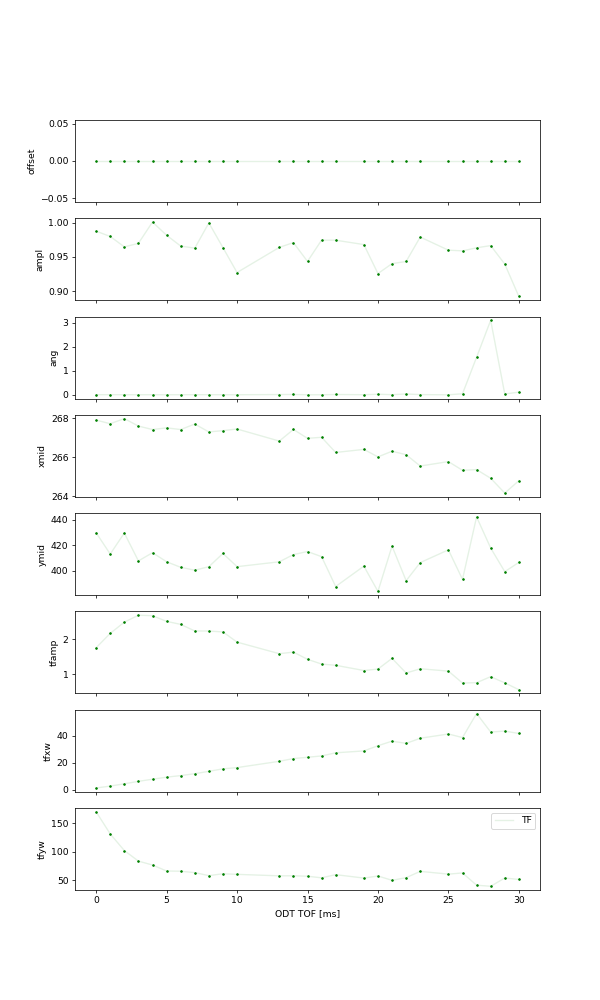

In [165]:
par_names = ['offset', 'ampl', 'ang', 'xmid', 'ymid', 'tfamp', 'tfxw', 'tfyw', 'gamp', 'gxw', 'gyw']

rd = 0 # Range data set (last 16)

# j = 0
# for i in [0, 1, 2, 3, 4, 8, 9, 10]:
#     # Gauss
#     data_gauss = [x[j] for x in odrout_gauss]
#     sorted_data_gauss = [x for _, x in sorted(zip(tof_all, data_gauss))]
#     sorted_tof = list(np.sort(tof_all))

#     ignores = 12, 17, 23
#     sorted_data_gauss = [x for i, x in enumerate(sorted_data_gauss) if i not in ignores]
#     sorted_tof = [x for i, x in enumerate(sorted_tof) if i not in ignores]
    
#     ax[i].plot(sorted_tof[rd:], sorted_data_gauss[rd:], c='r', alpha=0.1, label="gauss")
#     ax[i].scatter(sorted_tof[rd:], sorted_data_gauss[rd:], c='r', s=3)
#     ax[i].set_ylabel(par_names[i])    
#     j += 1


fig, ax = plt.subplots(8, 1, figsize=(9, 15), sharex=True)
for i in range(8):
    # TF
    data_tf = [x[i] for x in odrout_tf]
    sorted_data_tf = [x for _, x in sorted(zip(tof_all, data_tf))]
    sorted_tof = list(np.sort(tof_all))
    
    ignores = 12, 17, 23
    sorted_data_tf = [x for i, x in enumerate(sorted_data_tf) if i not in ignores]
    sorted_tof = [x for i, x in enumerate(sorted_tof) if i not in ignores]
    
    ax[i].plot(sorted_tof[rd:], sorted_data_tf[rd:], c='g', alpha=0.1, label="TF")
    ax[i].scatter(sorted_tof[rd:], sorted_data_tf[rd:], c='g', s=3)
    ax[i].set_ylabel(par_names[i])

    
    
# fig, ax = plt.subplots(11, 1, figsize=(9, 15), sharex=True)
# for i in range(11): 
#     # Bimodal
#     data_bimodal = [x[i] for x in odrout_bimodal]
#     sorted_data_bimodal = [x for _, x in sorted(zip(tof_all, data_bimodal))]
#     sorted_tof = np.sort(tof_all)
    
#     ignores = []
#     sorted_data_bimodal = [x for i, x in enumerate(sorted_data_bimodal) if i not in ignores]
#     sorted_tof = [x for i, x in enumerate(sorted_tof) if i not in ignores]
    
#     ax[i].plot(sorted_tof[rd:], sorted_data_bimodal[rd:], c='b', alpha=0.1, label="bimodal")
#     ax[i].scatter(sorted_tof[rd:], sorted_data_bimodal[rd:], c='b', s=3)
#     ax[i].set_ylabel(par_names[i])

ax[i].set_xlabel("ODT TOF [ms]")

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


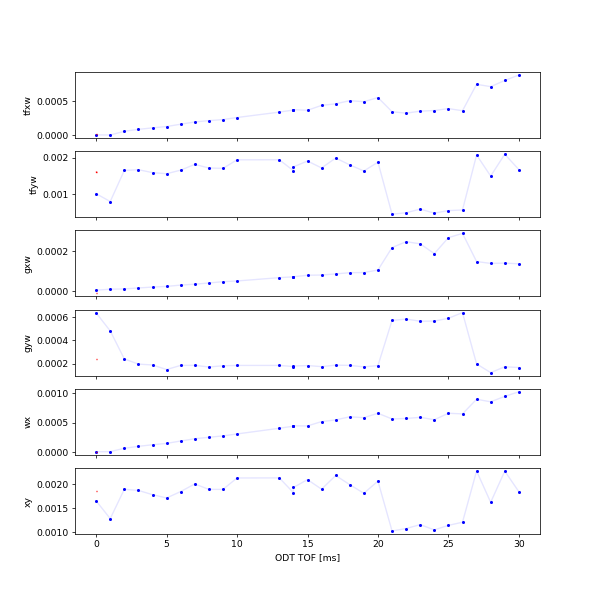

In [226]:
def lin(x, a, b):
    return a*x + b

pixelsize = 2.47148288973384e-6 *4 ## in microns  
xd = np.linspace(min(sorted_tof), max(sorted_tof), 1000)

par_names = ['tfxw', 'tfyw', 'gxw', 'gyw', 'wx', 'xy']
fig, ax = plt.subplots(6, 1, figsize=(9, 9), sharex=True)

data_tfx = np.array([x[6] for x in odrout_bimodal])
data_tfx = np.array([x for _, x in sorted(zip(tof_all, data_tfx))])*pixelsize

data_tfy = np.array([x[7] for x in odrout_bimodal])
data_tfy = np.array([x for _, x in sorted(zip(tof_all, data_tfy))])*pixelsize

data_gx = np.array([x[9] for x in odrout_bimodal])
data_gx = np.array([x for _, x in sorted(zip(tof_all, data_gx))])*pixelsize

data_gy = np.array([x[10] for x in odrout_bimodal])
data_gy = np.array([x for _, x in sorted(zip(tof_all, data_gy))])*pixelsize

data_x = data_tfx + data_gx
data_y = data_tfy + data_gy

all_data = [data_tfx, data_tfy, data_gx, data_gy, data_x, data_y]
sorted_tof = np.sort(tof_all)


for i in range(6):
    ax[i].plot(sorted_tof, all_data[i], c='b', alpha=0.1, label="bimodal")
    ax[i].scatter(sorted_tof, all_data[i], c='b', s=5)
    popt, pcov = curve_fit(lin, sorted_tof, all_data[i])
    ax[i].plot(xd, lin(xd, popt[0], popt[1]), c='r', ls='--', label=f"{popt}")
    ax[i].set_ylabel(par_names[i])

ax[5].set_xlabel("ODT TOF [ms]")
plt.show()

<IPython.core.display.Javascript object>


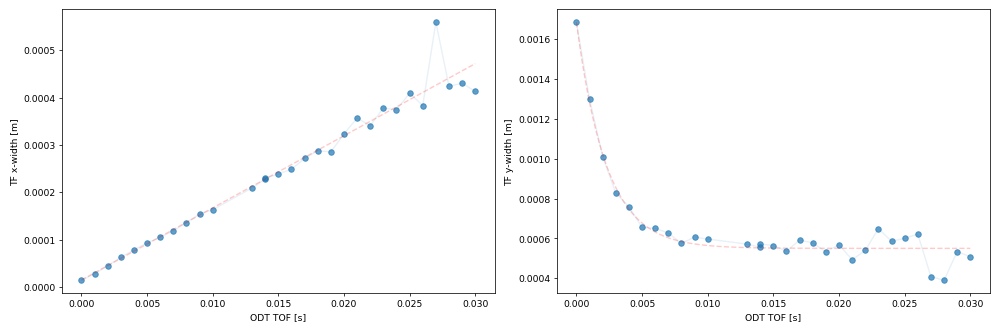

RADIAL:
Velocity= 15.238182449011592 mm/s
Halfsize in situ = 0.015238182449011593 m

AXIAL:
Velocity= 1.703664460820094 mm/s
Halfsize in situ = 0.001703664460820094 m


In [238]:
# if mode == "bimodal":
# def lin(x, a, b):
#     return a*x + b

# pixelsize = 2.47148288973384e-6 *4## in microns  
 
# par_names = ['tfxw', 'tfyw', 'gxw', 'gyw', 'wx[m]', 'xy']

# fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

# data_tfx = np.array([x[6] for x in odrout_bimodal])
# data_tfx = np.array([x for _, x in sorted(zip(tof_all, data_tfx))])*pixelsize
# data_tfy = np.array([x[7] for x in odrout_bimodal])
# data_tfy = np.array([x for _, x in sorted(zip(tof_all, data_tfy))])*pixelsize
# data_gx = np.array([x[9] for x in odrout_bimodal])
# data_gx = np.array([x for _, x in sorted(zip(tof_all, data_gx))])*pixelsize
# data_gy = np.array([x[10] for x in odrout_bimodal])
# data_gy = np.array([x for _, x in sorted(zip(tof_all, data_gy))])*pixelsize

# data_x = data_tfx + data_gx
# data_y = data_tfy + data_gy

# all_data = [data_tfx, data_tfy, data_gx, data_gy, data_x, data_y]
# sorted_tof = np.sort(tof_all) * 1e-3
# xd = np.linspace(min(sorted_tof), max(sorted_tof), 1000)

# ax[0].plot(sorted_tof, all_data[4], c='b', alpha=0.1, label="bimodal")
# ax[0].scatter(sorted_tof, all_data[4], c='b', s=5)
# popt, pcov = curve_fit(lin, sorted_tof, all_data[4])
# ax[0].plot(xd, lin(xd, popt[0], popt[1]), c='r', ls='--', label=f"{popt}")

# ax[0].set_ylabel('wx[m]')
# ax[0].set_xlabel("ODT TOF [s]")

# rad_v = popt[0]
# rad_w = popt[1]

# print("RADIAL:")
# print(f"Velocity= {popt[0]*1000} mm/s")
# print(f"Halfsize in situ = {popt[0]} m")

# ax[1].plot(sorted_tof, all_data[5], c='b', alpha=0.1, label="bimodal")
# ax[1].scatter(sorted_tof, all_data[5], c='b', s=5)
# popt, pcov = curve_fit(lin, sorted_tof[:21], all_data[5][:21])
# ax[1].plot(xd, lin(xd, popt[0], popt[1]), c='r', ls='--', label=f"{popt}")

# ax[1].set_ylabel('wy[m]')
# ax[1].set_xlabel("ODT TOF [s]")

# plt.show()

# z_v = popt[0]
# z_w = popt[1]
# print("AXIAL:")
# print(f"Velocity= {popt[0]*1000} mm/s")
# print(f"Halfsize in situ = {popt[0]} m\n")



# elif mode == "tf":
def lin(x, a, b):
    return a*x + b

def exp_dec(x, a, b, c, d):
    return a*np.exp(b*x + c) + d

pixelsize = 2.47148288973384e-6 * 4 # times 4 for binning  
par_names = ['tfxw', 'tfyw']
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
data_tfx = np.array([x[6] for x in odrout_tf])
data_tfx = np.array([x for _, x in sorted(zip(tof_all, data_tfx))])*pixelsize
data_tfy = np.array([x[7] for x in odrout_tf])
data_tfy = np.array([x for _, x in sorted(zip(tof_all, data_tfy))])*pixelsize

all_data = [data_tfx, data_tfy]
sorted_tof = np.sort(tof_all) * 1e-3
xd = np.linspace(min(sorted_tof), max(sorted_tof), 1000)

ax[0].plot(sorted_tof, all_data[0], c='C0', alpha=0.1, label="bimodal")
ax[0].scatter(sorted_tof, all_data[0], c='C0', alpha=0.7)
popt, pcov = curve_fit(lin, sorted_tof, all_data[0])
ax[0].plot(xd, lin(xd, popt[0], popt[1]), c='r', ls='--', alpha=0.21, label=f"{popt}")
ax[0].set_ylabel('TF x-width [m]')
ax[0].set_xlabel("ODT TOF [s]")
rad_v = popt[0]
rad_w = all_data[0][0]
print("RADIAL:")
print(f"Velocity= {popt[0]*1000} mm/s")
print(f"Halfsize in situ = {popt[0]} m\n")

ax[1].plot(sorted_tof, all_data[1], c='C0', alpha=0.1, label="bimodal")
ax[1].scatter(sorted_tof, all_data[1], c='C0', alpha=0.7)
popt, pcov = curve_fit(exp_dec, sorted_tof, all_data[1], p0=[4e-4, -4e2, -5e-1, 1e-4])
ax[1].plot(xd, exp_dec(xd, *popt), c='r', ls='--', alpha=0.21, label=f"{popt}")
ax[1].set_ylabel('TF y-width [m]')
ax[1].set_xlabel("ODT TOF [s]")
z_v = popt[0]
z_w = all_data[1][0]
print("AXIAL:")
print(f"Velocity= {popt[0]*1000} mm/s")
print(f"Halfsize in situ = {popt[0]} m")

plt.tight_layout()
plt.show()



In [201]:
def chem_potential(v):
    """ Calculates the chemical potential """
    mu = 1/2 * m * v**2 
    return mu

def trap_freq_z(mu, waist_z):
    """ Trapping frequency in z """
    f = np.sqrt( 2 * mu / (m * waist_z**2))
    return f/(2*np.pi)

def trap_freq_rho(mu, waist_z, N_0):
    """ Trapping frequency in rho """
    w_z = trap_freq_z(mu, waist_z)
    f = np.sqrt( (2 * mu)**(5/2) / (15 * hb**2 * m**(1/2) * N_0 * w_z * asc) )
    return f/(2*np.pi)

In [225]:
mu = chem_potential(rad_v)
f_z = trap_freq_z(mu, all_data[1][0])
f_rho = trap_freq_rho(mu, all_data[1][0], N_0=8e6)

print(f"{'Expans. velocity':20}: {round(rad_v*1000, 3)} mm/s")
print(f"{'Chemical potential':20}: {round(mu*1e30, 3)}e-30")
print("-"*40, "\n")

print("For a particle number of ~8 M (obtained through fitting):")
print(f"{'w_z':20}: {round(f_z, 3)} x 2π Hz")
print(f"{'w_r':20}: {round(f_rho, 2)} x 2π Hz")

mu = chem_potential(rad_v)
f_z = trap_freq_z(mu, all_data[1][0])
f_rho = trap_freq_rho(mu, all_data[1][0], N_0=60e6)
# print("\n" + "-"*40)

print("\nFor a particle number of ~60 M (obtained through counting pixels):")
print(f"{'w_z':20}: {round(f_z, 3)} x 2π Hz")
print(f"{'w_r':20}: {round(f_rho, 2)} x 2π Hz")

Expans. velocity    : 15.238 mm/s
Chemical potential  : 4.434e-30
---------------------------------------- 

For a particle number of ~8 M (obtained through fitting):
w_z                 : 1.44 x 2π Hz
w_r                 : 2374.3 x 2π Hz

For a particle number of ~60 M (obtained through counting pixels):
w_z                 : 1.44 x 2π Hz
w_r                 : 866.97 x 2π Hz


<IPython.core.display.Javascript object>


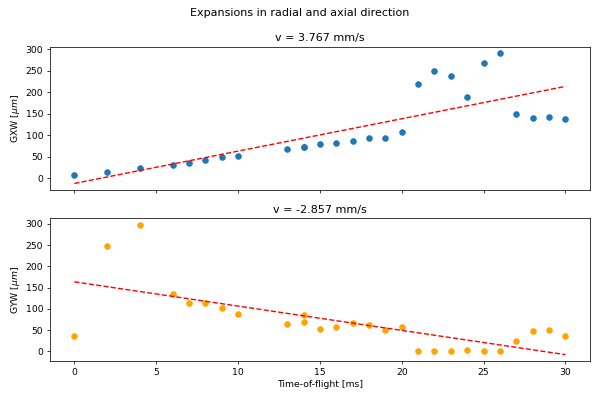

In [232]:
def lin(x, a, b):
    return a*x + b

pixelsize = 2.47148288973384 * 4 ## in microns  
xd = np.linspace(min(sorted_tof), max(sorted_tof), 1000)

# Just the widths 
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 6))
plt.suptitle("Expansions in radial and axial direction")

# Data generation and fixing
data_bimodal = [x[9]*pixelsize for x in odrout_bimodal]
sorted_data_bimodal = [x for _, x in sorted(zip(tof_all, data_bimodal))]
sorted_tof = list(np.sort(tof_all))

# Average duplicates / remove double tofs:
avg = (sorted_data_bimodal[0] + sorted_data_bimodal[1]) /2
sorted_data_bimodal[0] = avg
sorted_data_bimodal.pop(1) 
avg = (sorted_data_bimodal[1] + sorted_data_bimodal[2]) /2
sorted_data_bimodal[1] = avg
sorted_data_bimodal.pop(2) 
avg = (sorted_data_bimodal[2] + sorted_data_bimodal[3]) /2
sorted_data_bimodal[2] = avg
sorted_data_bimodal.pop(3) 
sorted_tof.pop(5)
sorted_tof.pop(3)
sorted_tof.pop(1)

# Fit with a linear curve
popt, pcov = curve_fit(lin, sorted_tof, sorted_data_bimodal)

# Plot
ax[0].scatter(sorted_tof, sorted_data_bimodal)
ax[0].plot(xd, lin(xd, popt[0], popt[1]), c='r', ls='--')
ax[0].set_ylabel("GXW [$\mu m$]")
ax[0].set_title("v = {:} mm/s".format(round(popt[0]/2, 3)))


##### SECOND AXIS
# Data generation and fixing
data_bimodal = [x[8]*pixelsize for x in odrout_bimodal]
sorted_data_bimodal = [x for _, x in sorted(zip(tof_all, data_bimodal))]
sorted_tof = list(np.sort(tof_all))
# Average duplicates / remove double tofs:
avg = (sorted_data_bimodal[0] + sorted_data_bimodal[1]) /2
sorted_data_bimodal[0] = avg
sorted_data_bimodal.pop(1) 
avg = (sorted_data_bimodal[1] + sorted_data_bimodal[2]) /2
sorted_data_bimodal[1] = avg
sorted_data_bimodal.pop(2) 
avg = (sorted_data_bimodal[2] + sorted_data_bimodal[3]) /2
sorted_data_bimodal[2] = avg
sorted_data_bimodal.pop(3) 
sorted_tof.pop(5)
sorted_tof.pop(3)
sorted_tof.pop(1)

# Fit with a linear curve
popt, pcov = curve_fit(lin, sorted_tof, sorted_data_bimodal)

# Plot
ax[1].scatter(sorted_tof, sorted_data_bimodal, c='orange')
ax[1].plot(xd, lin(xd, popt[0], popt[1]), c='r', ls='--')
ax[1].set_ylabel("GYW [$\mu m$]")
ax[1].set_title("v = {:} mm/s".format(round(popt[0]/2, 3)))
ax[1].set_xlabel("Time-of-flight [ms]")

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


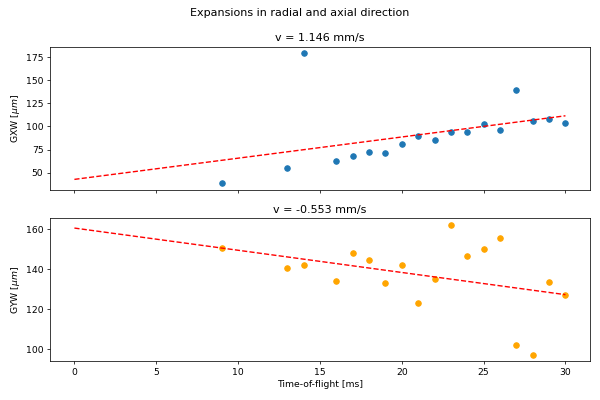

In [233]:
def lin(x, a, b):
    return a*x + b

pixelsize = 2.47148288973384 ## in microns  
xd = np.linspace(min(sorted_tof), max(sorted_tof), 1000)

# Just the widths 
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 6))
plt.suptitle("Expansions in radial and axial direction")

# Data generation and fixing
data_tf = [x[6]*pixelsize for x in odrout_tf]
sorted_data_tf = [x for _, x in sorted(zip(tof_all, data_tf))][-21:]
sorted_tof = list(np.sort(tof_all)[-21:])

# Average duplicates / remove double tofs:
avg = (sorted_data_bimodal[0] + sorted_data_tf[1]) /2
sorted_data_tf[0] = avg
sorted_data_tf.pop(1) 
avg = (sorted_data_tf[1] + sorted_data_tf[2]) /2
sorted_data_tf[1] = avg
sorted_data_tf.pop(2) 
avg = (sorted_data_bimodal[2] + sorted_data_tf[3]) /2
sorted_data_tf[2] = avg
sorted_data_tf.pop(3) 
sorted_tof.pop(5)
sorted_tof.pop(3)
sorted_tof.pop(1)

# Fit with a linear curve
popt, pcov = curve_fit(lin, sorted_tof, sorted_data_tf)

# Plot
ax[0].scatter(sorted_tof, sorted_data_tf)
ax[0].plot(xd, lin(xd, popt[0], popt[1]), c='r', ls='--')
ax[0].set_ylabel("GXW [$\mu m$]")
ax[0].set_title("v = {:} mm/s".format(round(popt[0]/2, 3)))


##### SECOND AXIS
# Data generation and fixing
data_tf = [x[7]*pixelsize for x in odrout_tf]
sorted_data_tf = [x for _, x in sorted(zip(tof_all, data_tf))][-21:]
sorted_tof = list(np.sort(tof_all)[-21:])
# Average duplicates / remove double tofs:
avg = (sorted_data_tf[0] + sorted_data_tf[1]) /2
sorted_data_tf[0] = avg
sorted_data_tf.pop(1) 
avg = (sorted_data_tf[1] + sorted_data_tf[2]) /2
sorted_data_tf[1] = avg
sorted_data_tf.pop(2) 
avg = (sorted_data_tf[2] + sorted_data_tf[3]) /2
sorted_data_tf[2] = avg
sorted_data_tf.pop(3) 
sorted_tof.pop(5)
sorted_tof.pop(3)
sorted_tof.pop(1)

# Fit with a linear curve
popt, pcov = curve_fit(lin, sorted_tof, sorted_data_tf)

# Plot
ax[1].scatter(sorted_tof, sorted_data_tf, c='orange')
ax[1].plot(xd, lin(xd, popt[0], popt[1]), c='r', ls='--')
ax[1].set_ylabel("GYW [$\mu m$]")
ax[1].set_title("v = {:} mm/s".format(round(popt[0]/2, 3)))
ax[1].set_xlabel("Time-of-flight [ms]")

plt.tight_layout()
plt.show()

## Dipole Cooling Characterization 

Particle number/temperature/efficiency vs cooling depth

In [647]:
# Get data
cool_depths = [get_parameter(20230502, shot, "coolval") for shot in range(47, 83)]
pnums = [get_fit_parameter(20230502, shot, "ntherm", "gauss") for shot in range(47, 83)]

# We did it in two runs, this one focused when the initial raise of the IR laser was 
# to 3, not to 6, as in the previous case.
cool_depths_pt2 = [get_parameter(20230502, shot, "coolval") for shot in range(107, 119)]
pnums_pt2 = [get_fit_parameter(20230502, shot, "ntherm", "gauss") for shot in range(107, 119)]


plt.figure(figsize=(9, 5))
plt.scatter(cool_depths[0::3], pnums[0::3], alpha=0.5, c='r', marker='x', label="Cooling Time = 0.5 s")
plt.scatter(cool_depths[1::3], pnums[1::3], alpha=0.5, c='g', marker='x', label="Cooling Time = 1.0 s")
plt.scatter(cool_depths[2::3], pnums[2::3], alpha=0.5, c='b', marker='x', label="Cooling Time = 2.0 s")
plt.scatter(cool_depths_pt2, pnums_pt2, alpha=0.5, c='g', marker='x')
plt.axvspan(0.8, 1.2, alpha=0.3, color='gray', label="Condensate begins appearing")


plt.title("Particle Number vs Cooling Depth (& Cooling Time)")
plt.xlabel("Cooling depth [V]")
plt.ylabel("Particle number")
plt.gca().invert_xaxis()
plt.legend()
plt.savefig("/home/bec_lab/Desktop/imgs/ODT/cooling/pnum_vs_cooling.png")
plt.show()


print("Note: The values of cooling are in terms of how much voltage we supply to the AOM driver.",
      "With this, we lower the power, but the two are likely not linearly related.", 
      "Furthermore, all these fits were done assuming a gaussian distribution, for which time-of-flight,",
      "of 200ms was assumed - far more than the actual dipole time-of-flight, which was 3ms in all cases.",
      "So the shape of the curve should be reliable, while the actual number not so much.")

<IPython.core.display.Javascript object>

Note: The values of cooling are in terms of how much voltage we supply to the AOM driver. With this, we lower the power, but the two are likely not linearly related. Furthermore, all these fits were done assuming a gaussian distribution, for which time-of-flight, of 200ms was assumed - far more than the actual dipole time-of-flight, which was 3ms in all cases. So the shape of the curve should be reliable, while the actual number not so much.


In [648]:
# Get data
cool_depths = [get_parameter(20230502, shot, "coolval") for shot in range(47, 83)]
pnums = [get_fit_parameter(20230502, shot, "tx", "gauss") for shot in range(47, 83)]

# We did it in two runs, this one focused when the initial raise of the IR laser was 
# to 3, not to 6, as in the previous case.
cool_depths_pt2 = [get_parameter(20230502, shot, "coolval") for shot in range(107, 119)]
pnums_pt2 = [get_fit_parameter(20230502, shot, "tx", "gauss") for shot in range(107, 119)]


plt.figure(figsize=(9, 5))
plt.scatter(cool_depths[0::3], pnums[0::3], alpha=0.5, c='r', marker='x', label="Cooling Time = 0.5 s")
plt.scatter(cool_depths[1::3], pnums[1::3], alpha=0.5, c='g', marker='x', label="Cooling Time = 1.0 s")
plt.scatter(cool_depths[2::3], pnums[2::3], alpha=0.5, c='b', marker='x', label="Cooling Time = 2.0 s")
plt.scatter(cool_depths_pt2, pnums_pt2, alpha=0.5, c='g', marker='x')
plt.axvspan(0.8, 1.2, alpha=0.3, color='gray', label="Condensate begins appearing")


plt.title("Temperature-X vs Cooling Depth (& Cooling Time)")
plt.xlabel("Cooling depth [V]")
plt.ylabel("Temperature X [K]")
plt.gca().invert_xaxis()
plt.legend()
plt.savefig("/home/bec_lab/Desktop/imgs/ODT/cooling/TX_vs_cooling.png")
plt.show()

print("Note: The values of cooling are in terms of how much voltage we supply to the AOM driver.",
      "With this, we lower the power, but the two are likely not linearly related.", 
      "Furthermore, all these fits were done assuming a gaussian distribution, for which time-of-flight,",
      "for which 200ms was assumed - far more than the actual dipole time-of-flight, which was 3ms in all cases.",
      "So the shape of the curve should be reliable, while the actual number not so much.")

<IPython.core.display.Javascript object>

Note: The values of cooling are in terms of how much voltage we supply to the AOM driver. With this, we lower the power, but the two are likely not linearly related. Furthermore, all these fits were done assuming a gaussian distribution, for which time-of-flight, for which 200ms was assumed - far more than the actual dipole time-of-flight, which was 3ms in all cases. So the shape of the curve should be reliable, while the actual number not so much.


In [649]:
# Get data
cool_depths = [get_parameter(20230502, shot, "coolval") for shot in range(47, 83)]
pnums = [get_fit_parameter(20230502, shot, "tz", "gauss") for shot in range(47, 83)]

# We did it in two runs, this one focused when the initial raise of the IR laser was 
# to 3, not to 6, as in the previous case.
cool_depths_pt2 = [get_parameter(20230502, shot, "coolval") for shot in range(107, 119)]
pnums_pt2 = [get_fit_parameter(20230502, shot, "tz", "gauss") for shot in range(107, 119)]


plt.figure(figsize=(9, 5))
plt.scatter(cool_depths[0::3], pnums[0::3], alpha=0.5, c='r', marker='x', label="Cooling Time = 0.5 s")
plt.scatter(cool_depths[1::3], pnums[1::3], alpha=0.5, c='g', marker='x', label="Cooling Time = 1.0 s")
plt.scatter(cool_depths[2::3], pnums[2::3], alpha=0.5, c='b', marker='x', label="Cooling Time = 2.0 s")
plt.scatter(cool_depths_pt2, pnums_pt2, alpha=0.5, c='g', marker='x')
plt.axvspan(0.8, 1.2, alpha=0.3, color='gray', label="Condensate begins appearing")


plt.title("Temperature-Z vs Cooling Depth (& Cooling Time)")
plt.xlabel("Cooling depth [V]")
plt.ylabel("Temperature Z [K]")
plt.gca().invert_xaxis()
plt.legend()
plt.savefig("/home/bec_lab/Desktop/imgs/ODT/cooling/TZ_vs_cooling.png")
plt.show()

print("Note: The values of cooling are in terms of how much voltage we supply to the AOM driver.",
      "With this, we lower the power, but the two are likely not linearly related.", 
      "Furthermore, all these fits were done assuming a gaussian distribution, for which time-of-flight,",
      "for which 200ms was assumed - far more than the actual dipole time-of-flight, which was 3ms in all cases.",
      "So the shape of the curve should be reliable, while the actual number not so much.")

<IPython.core.display.Javascript object>

Note: The values of cooling are in terms of how much voltage we supply to the AOM driver. With this, we lower the power, but the two are likely not linearly related. Furthermore, all these fits were done assuming a gaussian distribution, for which time-of-flight, for which 200ms was assumed - far more than the actual dipole time-of-flight, which was 3ms in all cases. So the shape of the curve should be reliable, while the actual number not so much.


In [650]:
# Get data
cool_depths = [get_parameter(20230502, shot, "coolval") for shot in range(47, 83)]
gamp = [get_fit_parameter(20230502, shot, "gamp_p", "gauss") for shot in range(47, 83)]
gxw = [get_fit_parameter(20230502, shot, "gxw_p", "gauss") for shot in range(47, 83)]
gyw = [get_fit_parameter(20230502, shot, "gyw_p", "gauss") for shot in range(47, 83)]
tx = [get_fit_parameter(20230502, shot, "tx", "gauss") for shot in range(47, 83)]
tz = [get_fit_parameter(20230502, shot, "tz", "gauss") for shot in range(47, 83)]

N = 2*np.pi * np.array(gamp) * np.array(gxw) * np.array(gyw)
V = (2*np.pi)**(3/2) * np.array(gxw)**2 * np.array(gyw)
density = N/V
gamma = density * np.sqrt(((np.array(tx)+np.array(tz)) * 0.5))


# We did it in two runs, this one focused when the initial raise of the IR laser was 
# to 3, not to 6, as in the previous case.
cool_depths_pt2 = [get_parameter(20230502, shot, "coolval") for shot in range(107, 119)]
pnums_pt2 = [get_fit_parameter(20230502, shot, "tz", "gauss") for shot in range(107, 119)]
gamp = [get_fit_parameter(20230502, shot, "gamp_p", "gauss") for shot in range(107, 119)]
gxw = [get_fit_parameter(20230502, shot, "gxw_p", "gauss") for shot in range(107, 119)]
gyw = [get_fit_parameter(20230502, shot, "gyw_p", "gauss") for shot in range(107, 119)]
tx = [get_fit_parameter(20230502, shot, "tx", "gauss") for shot in range(107, 119)]
tz = [get_fit_parameter(20230502, shot, "tz", "gauss") for shot in range(107, 119)]

N = 2*np.pi * np.array(gamp) * np.array(gxw) * np.array(gyw)
V = (2*np.pi)**(3/2) * np.array(gxw)**2 * np.array(gyw)
density = N/V
gamma_2 = density * np.sqrt(((np.array(tx)+np.array(tz)) * 0.5))
  
plt.figure(figsize=(9, 5))
plt.scatter(cool_depths[0::3], gamma[0::3], alpha=0.5, c='r', marker='x', label="Cooling Time = 0.5 s")
plt.scatter(cool_depths[1::3], gamma[1::3], alpha=0.5, c='g', marker='x', label="Cooling Time = 1.0 s")
plt.scatter(cool_depths[2::3], gamma[2::3], alpha=0.5, c='b', marker='x', label="Cooling Time = 2.0 s")
plt.scatter(cool_depths_pt2, gamma_2, alpha=0.5, c='g', marker='x')
plt.axvspan(0.8, 1.2, alpha=0.3, color='gray', label="Condensate begins appearing")


plt.title("Efficiency vs Cooling Depth (& Cooling Time)")
plt.xlabel("Cooling depth [V]")
plt.ylabel("$\gamma$ [arb.]")
plt.gca().invert_xaxis()
plt.legend()
plt.savefig("/home/bec_lab/Desktop/imgs/ODT/cooling/eff_vs_cooling.png")
plt.show()

print("Note: The values of cooling are in terms of how much voltage we supply to the AOM driver.",
      "With this, we lower the power, but the two are likely not linearly related.", 
      "Furthermore, all these fits were done assuming a gaussian distribution, for which time-of-flight,",
      "for which 200ms was assumed - far more than the actual dipole time-of-flight, which was 3ms in all cases.",
      "So the shape of the curve should be reliable, while the actual number not so much.")

<IPython.core.display.Javascript object>

Note: The values of cooling are in terms of how much voltage we supply to the AOM driver. With this, we lower the power, but the two are likely not linearly related. Furthermore, all these fits were done assuming a gaussian distribution, for which time-of-flight, for which 200ms was assumed - far more than the actual dipole time-of-flight, which was 3ms in all cases. So the shape of the curve should be reliable, while the actual number not so much.


## Weird stripey thing

We noticed some weird stripey thing in the condensate, so let's take the FFT, naturally. 

<b>Run:</b> 20230503/0083

In [ ]:
date = 20230503
shot = 83

atom, flat, dark = openFiles(date, shot, num, multi_loop=0)

pic = (atom - dark) / (flat - dark)
pic[pic < 0.0001] = 0.0001
mask = flat - dark < 25.
pic = np.ma.array(pic, mask=mask)
pic = pic[1075:1175, 900:1350]

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].imshow(pic, vmin=-0.3, vmax=1., cmap="afmhot_r")
ax[1].plot(pic[50], c='C0')
ax[0].axhline(y=50, ls='--', alpha=0.5, c='C0')

plt.show()


In [ ]:
from matplotlib.colors import LogNorm

fft_2D = np.fft.fft2(pic)
shift_2D = np.fft.fftshift(fft_2D)


fig, ax = plt.subplots(4, 1,  figsize=(8, 6))
fig.suptitle("{:}_{:}".format(date, shot))

im1 = ax[0].imshow(pic, aspect='auto', cmap='afmhot_r', vmin=-0.3, vmax=1.)
im2 = ax[1].imshow(abs(shift_2D), aspect='auto', cmap='afmhot', norm=LogNorm())

for lc in [50]:
    fft_lcut = np.fft.fft(pic[lc])
    shift_lcut = np.fft.fftshift(fft_lcut)
    ax[0].axhline(y=lc, ls='--', alpha=0.5)
    ax[2].plot(pic[lc])
    ax[3].plot(abs(shift_lcut))
    plt.yscale("log")

    
for i in [0,1,2,3]:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    
# plt.colorbar(im1, ax=ax[:], orientation="horizontal", aspect=40)
# plt.colorbar(im2, ax=ax[:], orientation="horizontal", aspect=40)
plt.tight_layout()
plt.show()


## Investigationg the motion of the cloud

This might be caused by some motion of the cloud, so we took images of the cloud at different times after moving it to the IR trap.

In [ ]:
# Get data
start = 202
stop = 222

probeshut = [get_parameter(20230504, shot, "probeshut") for shot in range(start, stop)]
pnums = [get_fit_parameter(20230504, shot, "ntherm", "gauss")/1e6 for shot in range(start, stop)]
xmid = [get_fit_parameter(20230504, shot, "xmid", "gauss") for shot in range(start, stop)]
ymid = [get_fit_parameter(20230504, shot, "ymid", "gauss") for shot in range(start, stop)]
gxw = [get_fit_parameter(20230504, shot, "gxw", "gauss") for shot in range(start, stop)]
gyw = [get_fit_parameter(20230504, shot, "gyw", "gauss") for shot in range(start, stop)]

data = [pnums, xmid, ymid, gxw, gyw]
data_names = ['pnum [M]', 'xmid', 'ymid', 'gxw', 'gyw']

fig, ax = plt.subplots(5, 1, figsize=(8, 5), sharex=True)
for i in range(5):
    ysorted = [x for _, x in sorted(zip(probeshut, data[i]))]
    ax[i].scatter(probeshut, ysorted, alpha=0.5, c='r', marker='x')
    ax[i].plot(probeshut, ysorted, alpha=0.1, c='r')#, marker='x')
    ax[i].set_ylabel(data_names[i])

ax[4].set_xlabel("Time [ms]")
fig.align_ylabels()
# plt.title("Particle Number vs Cooling Depth (& Cooling Time)")
# plt.xlabel("Cooling depth [V]")
# plt.ylabel("Particle number")
# plt.gca().invert_xaxis()
# plt.legend()
# plt.savefig("/home/bec_lab/Desktop/imgs/ODT/cooling/pnum_vs_cooling.png")
plt.show()

## OAH Defocusing in the trap

In [ ]:
print(odrout.beta[2]*(180/np.pi))

In [ ]:
# Also rotation 
# Initial values
amp_ov = 1.
ang = 0 
center = (35, 300)
tfa = 1
tfw = (5, 200)
ga = 1
gw = (200, 200)
j_guess = 40 
axamp = 1
x_shift = 0.0
squeeze_par = 1.0

pic, fitresult, fitguess, fitresultgauss, fitresulttf, fitted_vars, odrout = fitting(cut_ang, 'tf', invert=True)
pic = rotate(pic, (odrout.beta[2]*(180/np.pi)), mode='reflect')
fitresult = rotate(fitresult, (odrout.beta[2]*(180/np.pi)), mode='reflect')
if pic.shape[0] > pic.shape[1]:
    pic = np.transpose(np.transpose(np.transpose(pic)))
    fitresult = np.transpose(np.transpose(np.transpose(fitresult)))

fig, ax = plt.subplots(3,1)
ax[0].imshow(pic, vmin=-0.5, vmax=0.5)
ax[1].imshow(fitguess,  vmin=-0.5, vmax=0.5)
ax[2].imshow(fitresult,  vmin=-0.5, vmax=0.5)

In [ ]:
date = 20230523
shot = 201
num = 0 

save_folder = "/home/bec_lab/Desktop/imgs/ODT/defocus/{:}_{:}/".format(date, shot)

if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    
all_times = []
all_pnums = []

f_range = np.linspace(-0.02, 0.0, 500)

i = 0
lc = 40
lc_shift = 8

for dz_focus in f_range:
    print("Saving focus ", dz_focus)
    atoms, flat, dark, fft_atoms, fft_flat, ang1, amp = fft_analysis(date, shot, num, dz_focus, quad_cut="quad2", multi_loop=0)
    
    cut_ang = ang1[1084:1155, 800:1472]
    cut_ang = rotate(cut_ang, 0.5604924994393712, mode='reflect')


    fig, ax = plt.subplots(3, 1, figsize=(7,7))
    ax[0].imshow(cut_ang, vmin=-0.5, vmax=0.5, cmap="afmhot_r", aspect='auto')
    ax[0].axhline(y=lc, xmin=0, xmax=100/672, alpha=0.85, c='C3')
    ax[0].axhline(y=lc, xmin=500/672, xmax=1, alpha=0.85, c='C3')
#     ax[0].fill_between(np.linspace(0, 672, 5), lc-lc_shift, lc+lc_shift, alpha=0.2)
    ax[0].axhline(y=lc-lc_shift, alpha=0.5)
    ax[0].axhline(y=lc+lc_shift, alpha=0.5)

    ax[1].plot(cut_ang[lc], c='C3', alpha=0.7)
    ax[2].plot(np.sum(cut_ang[lc-lc_shift:lc+lc_shift, :] , axis=0), c='C0', alpha=0.7)
    
    ax[1].set_title("Linecut through the middle")
    ax[2].set_title("Integrated linecut")
    plt.suptitle("{:} {:}\nfocus = {:}".format(date, shot, round(dz_focus, 4)))
    plt.tight_layout()
    plt.savefig(save_folder + "{:}.png".format(str(i).zfill(5)))
    plt.close()
    i += 1
    clear_output(wait=True)



## TOF Spinpol 

In [ ]:
date = 20230717
seq = 66
pic = makeAPic(date, seq, multi_loop=0)[725:1400, 671:1700]
tof = get_parameter(date, seq, 'tof')
fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
ax.imshow(pic, vmin=0, vmax=1.3, cmap='afmhot_r', interpolation=None, origin="lower")
ax.set_title("time-of-flight = {:}".format(tof))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
date = 20230717
seq = 66

for seq in range(38, 80):
    pic = makeAPic(date, seq, multi_loop=0)[725:1400, 671:1700]
    tof = get_parameter(date, seq, 'tof')
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(9,7))
    ax.imshow(pic, vmin=0, vmax=1.3, cmap='afmhot_r', interpolation=None, origin="lower")
    ax.set_title("time-of-flight = {:}".format(tof))
    ax.set_xticks([])
    ax.set_yticks([])
    
    if os.path.isfile("/home/bec_lab/Desktop/imgs/ODT/ODT_tof/{:}.jpg".format(str(int(tof)).zfill(4))):
        plt.savefig("/home/bec_lab/Desktop/imgs/ODT/ODT_tof/{:}_1.jpg".format(str(int(tof)).zfill(4)))
    else: 
        plt.savefig("/home/bec_lab/Desktop/imgs/ODT/ODT_tof/{:}.jpg".format(str(int(tof)).zfill(4)))

    plt.close()

    i += 1

In [ ]:
### MAKE A MOVIE 

save_folder = '/home/bec_lab/Desktop/imgs/ODT/ODT_tof/'
    
images = []
for filename in sorted(os.listdir(save_folder)):
    print("Moviefying ", filename)
    images.append(imageio.imread(save_folder + filename))
    clear_output(wait=True)
imageio.mimsave('/home/bec_lab/Desktop/imgs/ODT/{:}_videoimgs.mov'.format(date), images, fps=7)
imageio.mimsave('/home/bec_lab/Desktop/imgs/ODT/{:}_gifimgs.gif'.format(date), images, fps=7)
print("Moviefying completed!")

## Investigating the stripy behaviour

In [13]:
date = 20230720
seq = 140
pic = makeAPic(date, seq, multi_loop=0)[725:1400, 671:1800]
cd = get_parameter(date, seq, 'odttime')
fig, ax = plt.subplots(1,1, sharex=True, sharey=True)
ax.imshow(pic, vmin=0, vmax=1.3, cmap='afmhot_r', interpolation='none', origin="lower")
ax.set_title("Cooling Time = {:} s".format(cd/1000))
ax.set_xticks([])
ax.set_yticks([])
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
date = 20230720
seq = 100
for seq in range(122, 142):
    pic = makeAPic(date, seq, multi_loop=0)[725:1400, 671:1800]
    cd = get_parameter(date, seq, 'odttime')
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(9,7))
    ax.imshow(pic, vmin=0, vmax=1.3, cmap='afmhot_r', interpolation=None, origin="lower")
    ax.set_title("Quench Time (cooling time) = {:} s".format(cd/1000))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig("/home/bec_lab/Desktop/imgs/ODT/ODT_stripes_odttime/{:}.jpg".format(str(int(cd*100)).zfill(4)))
    plt.close()

In [14]:
pic = makeAPic(20230801, 16, num=0, multi_loop=0)

pic1 = pic[925:1225, 850:1550]
pic2 = pic[1450:1750, 850:1550]
plot1 = np.sum(pic1, axis=0)
plot2 = np.sum(pic2, axis=0)

fig, (ax, ax05, ax1, ax15, axc) = plt.subplots(5,1, figsize=(8,7))

ax.imshow(pic1, vmin=0, vmax=1.3, cmap='afmhot_r', interpolation='none', origin="lower", aspect='auto')
ax05.plot(plot1, c='C0')
ax1.imshow(pic2, vmin=0, vmax=1.3, cmap='afmhot_r', interpolation='none', origin="lower", aspect='auto')
ax15.plot(plot2, c='C1')
axc.plot(plot1, c='C0', alpha=0.5)
axc.plot(plot2, c='C1', alpha=0.5)

ax.set_title("$m_f = 0$")
ax1.set_title("$m_f = -1$")
ax1.set_xticks([])
ax1.set_yticks([])
ax.set_xticks([])
ax.set_yticks([])
ax15.set_xticks([])
ax15.set_yticks([])
ax05.set_xticks([])
ax05.set_yticks([])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

## Wide trap, with cooling

/home/bec_lab/python/BECViewer/pckg/fit/OAHDEV_functions.py:95: RuntimeWarning: invalid value encountered in divide
  pic = (atom - dark) / (flat - dark)


<IPython.core.display.Javascript object>


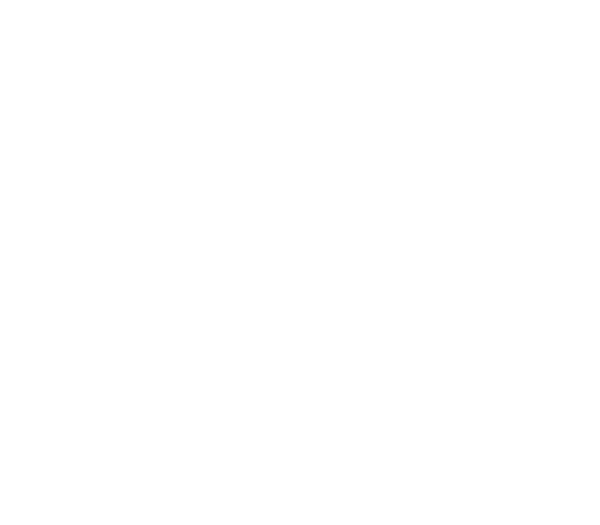

<IPython.core.display.Javascript object>


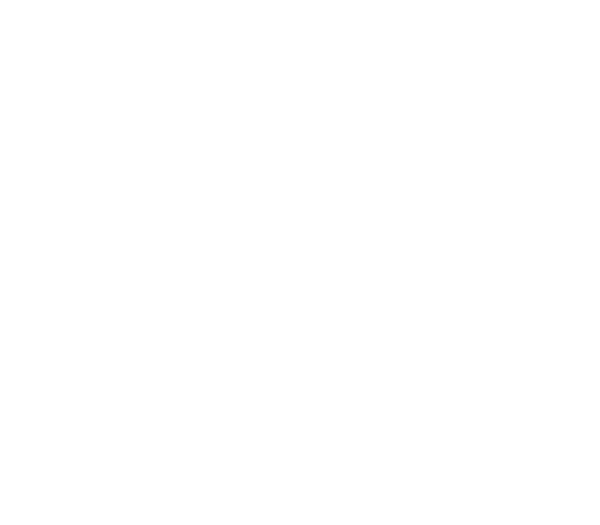

<IPython.core.display.Javascript object>


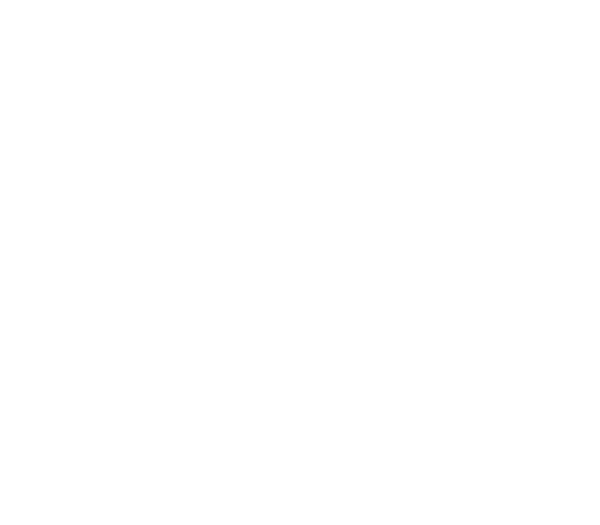

<IPython.core.display.Javascript object>


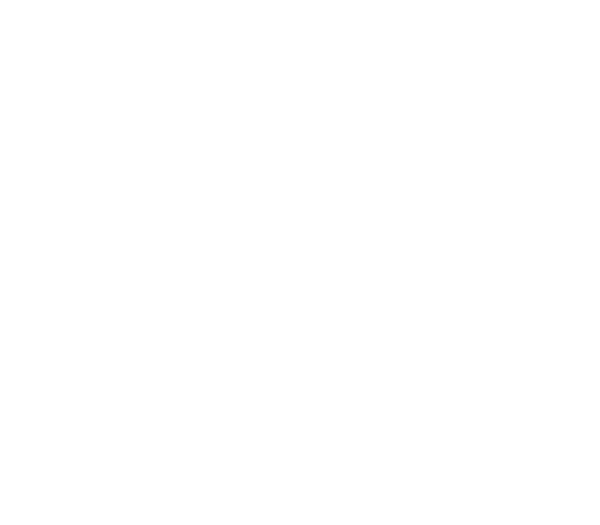

<IPython.core.display.Javascript object>


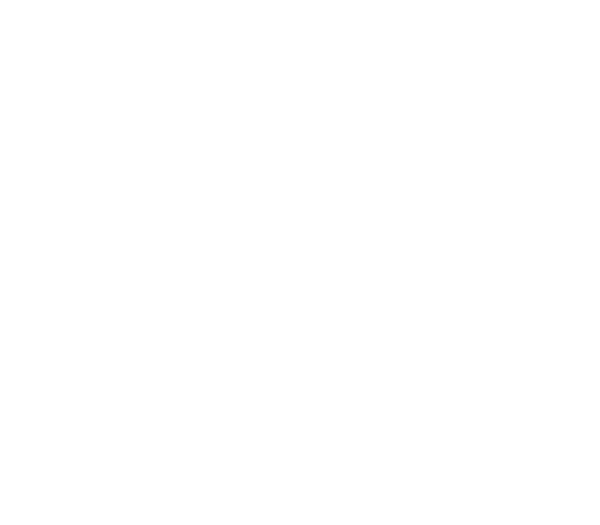

<IPython.core.display.Javascript object>


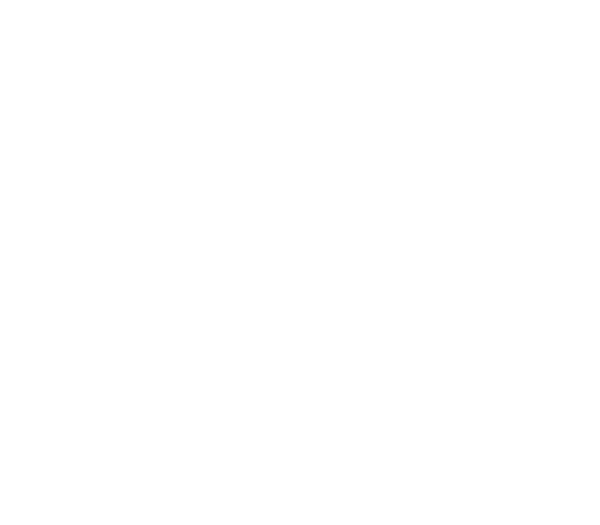

<IPython.core.display.Javascript object>


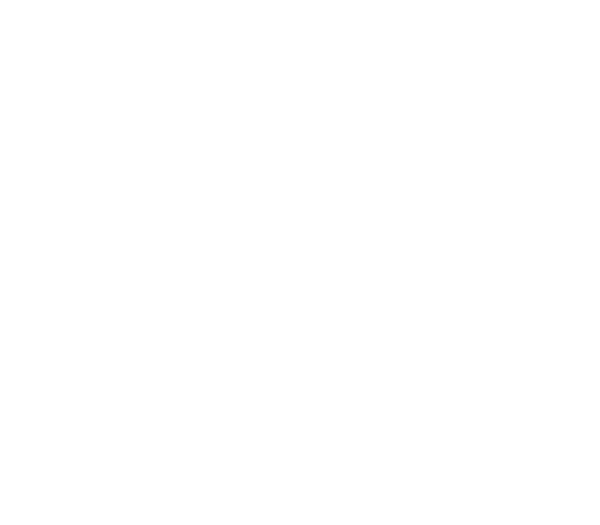

<IPython.core.display.Javascript object>


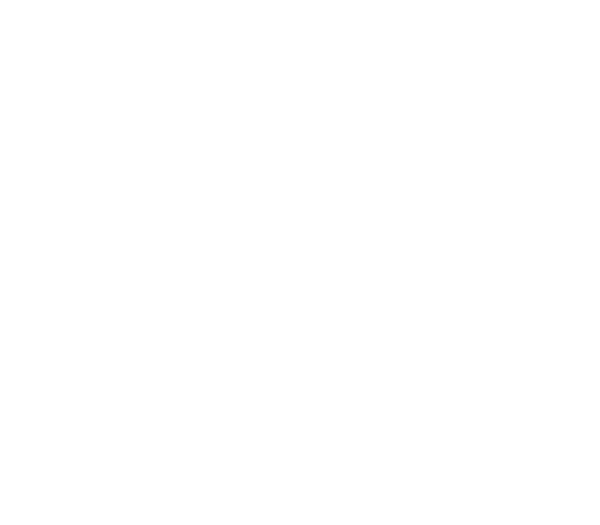

<IPython.core.display.Javascript object>


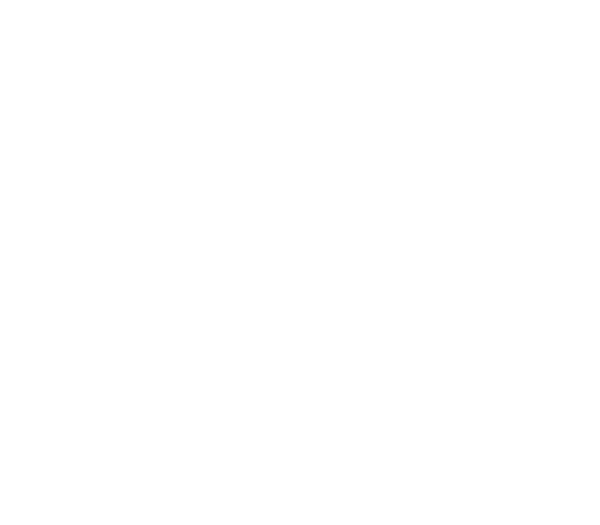

<IPython.core.display.Javascript object>


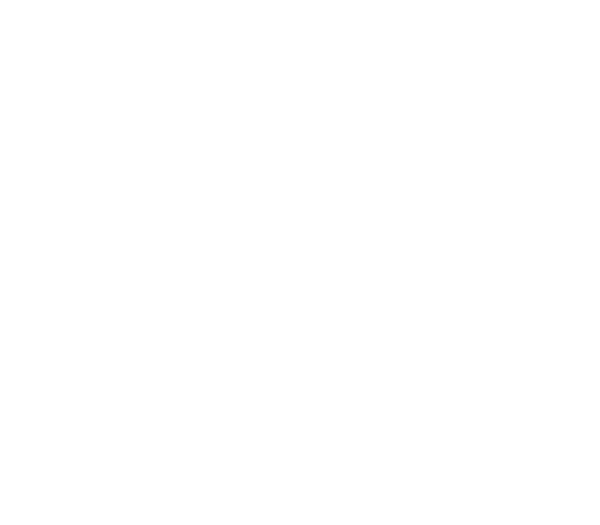

<IPython.core.display.Javascript object>


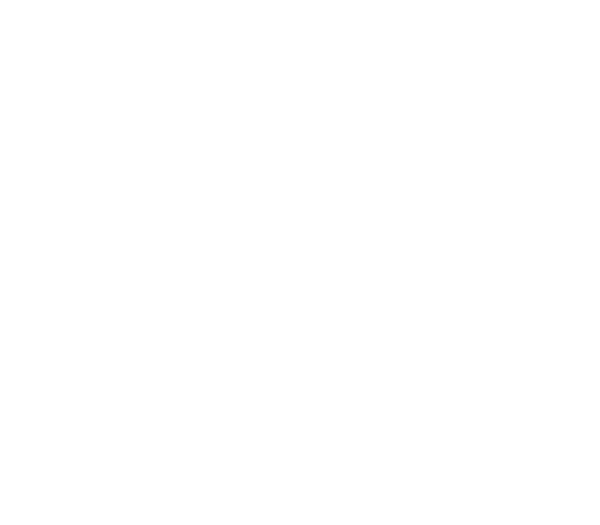

<IPython.core.display.Javascript object>


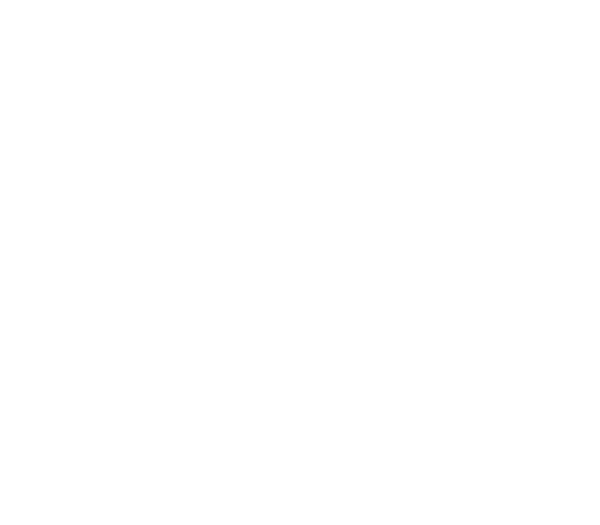

<IPython.core.display.Javascript object>


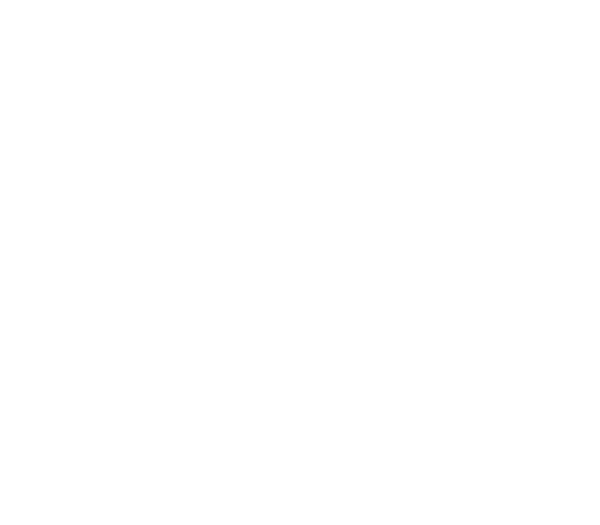

<IPython.core.display.Javascript object>


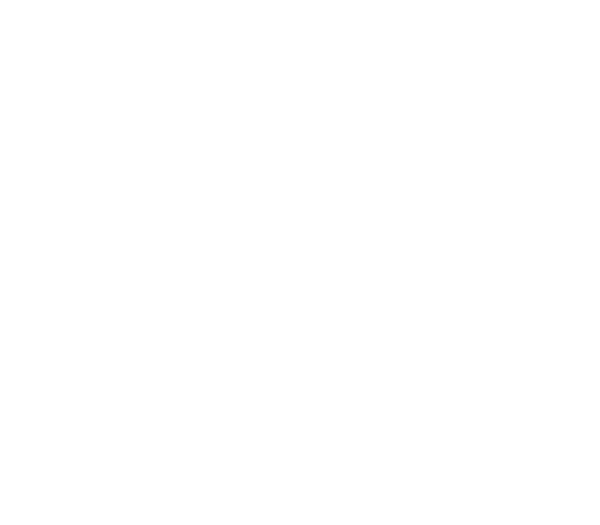

<IPython.core.display.Javascript object>


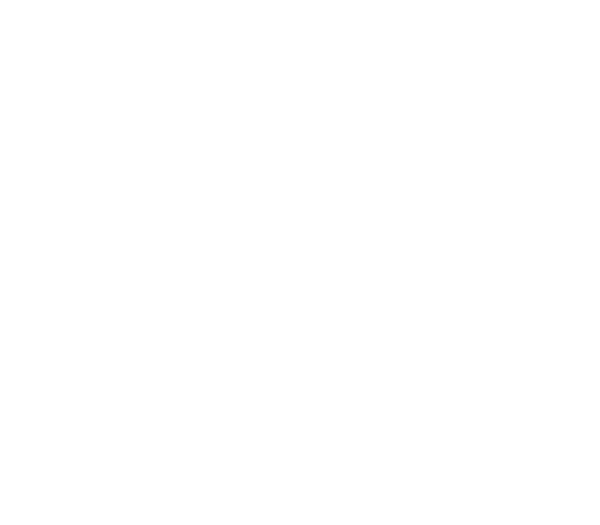

<IPython.core.display.Javascript object>


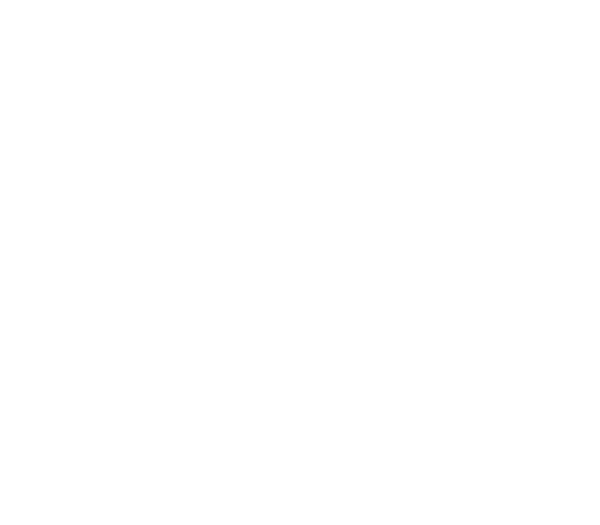

<IPython.core.display.Javascript object>


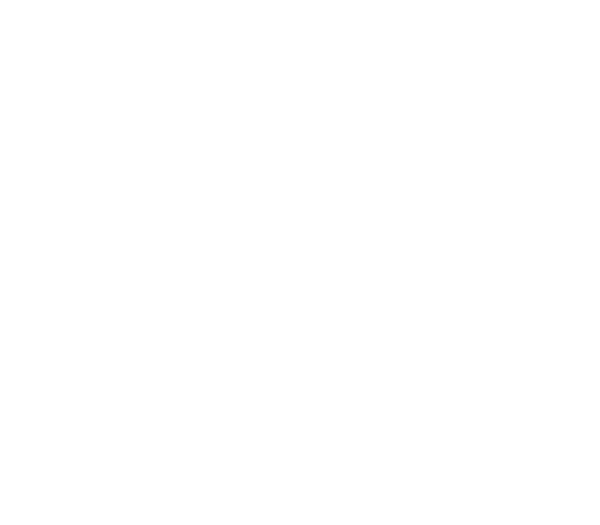

<IPython.core.display.Javascript object>


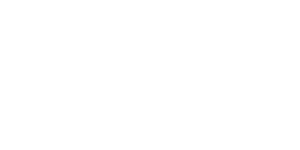

<IPython.core.display.Javascript object>


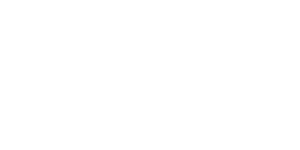

/home/bec_lab/python/BECViewer/pckg/fit/OAHDEV_functions.py:95: RuntimeWarning: divide by zero encountered in divide
  pic = (atom - dark) / (flat - dark)


<IPython.core.display.Javascript object>


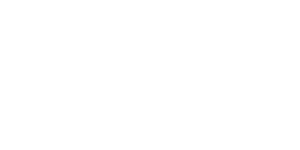

<IPython.core.display.Javascript object>


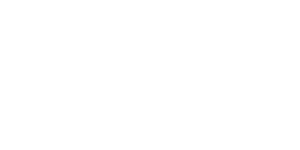

<IPython.core.display.Javascript object>


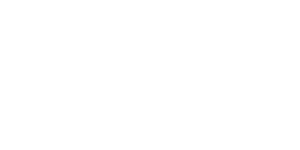

<IPython.core.display.Javascript object>


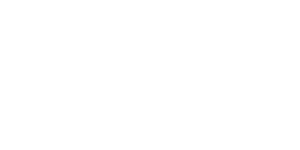

<IPython.core.display.Javascript object>


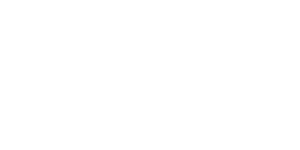

<IPython.core.display.Javascript object>


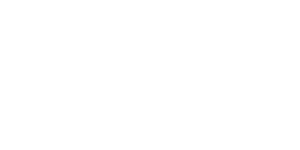

<IPython.core.display.Javascript object>


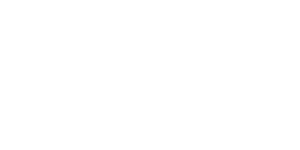

<IPython.core.display.Javascript object>


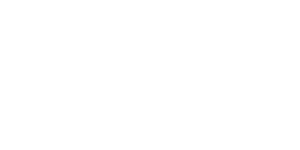

<IPython.core.display.Javascript object>


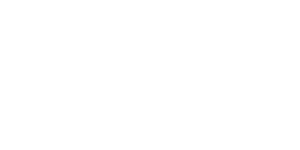

<IPython.core.display.Javascript object>


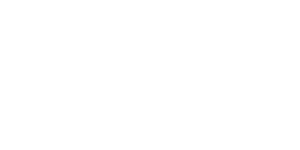

<IPython.core.display.Javascript object>


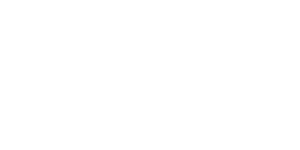

<IPython.core.display.Javascript object>


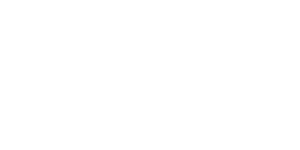

<IPython.core.display.Javascript object>


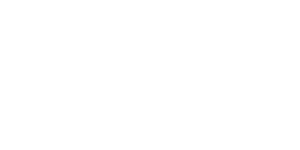

<IPython.core.display.Javascript object>


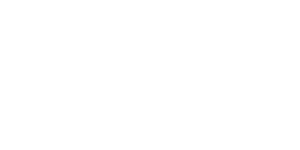

<IPython.core.display.Javascript object>


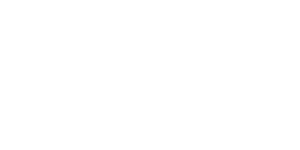

<IPython.core.display.Javascript object>


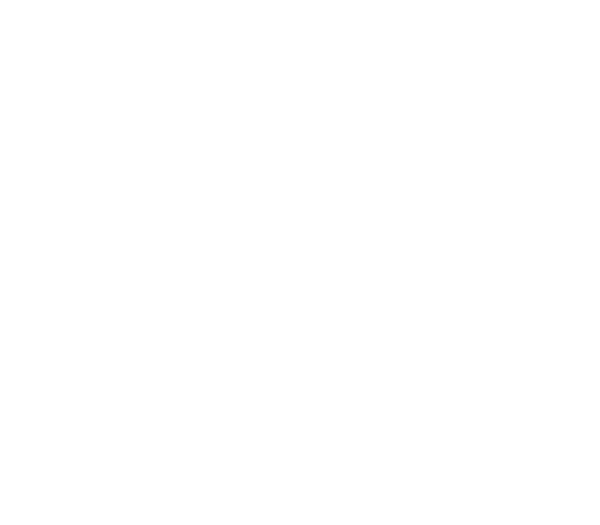

<IPython.core.display.Javascript object>


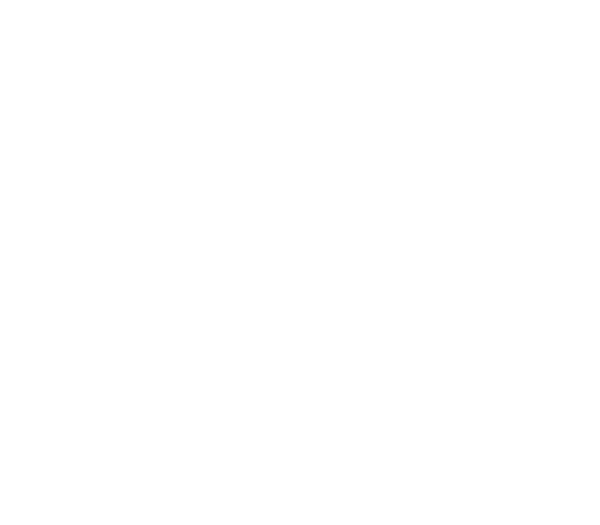

<IPython.core.display.Javascript object>


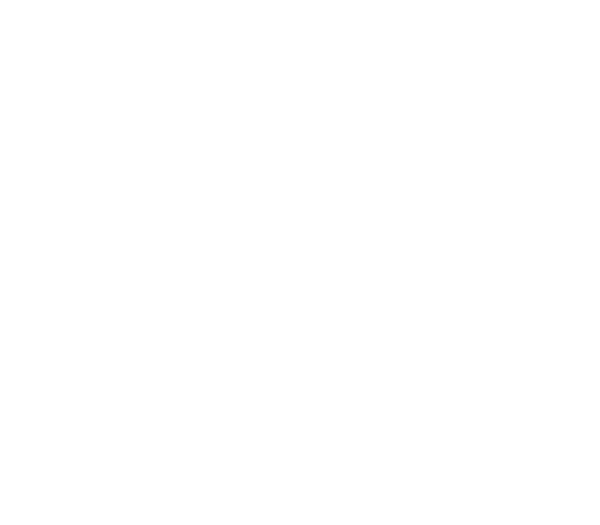

<IPython.core.display.Javascript object>


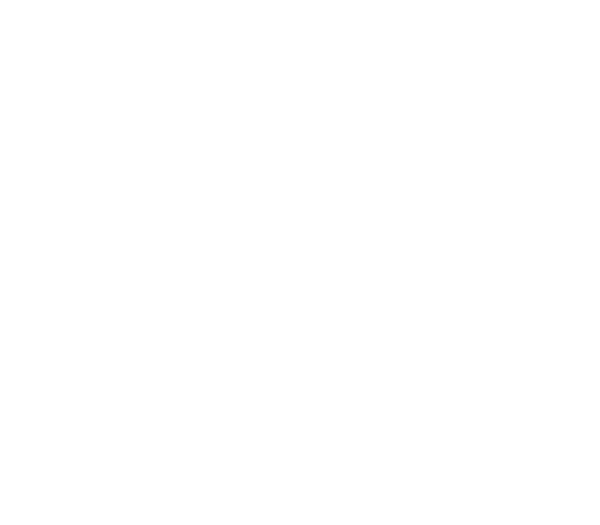

<IPython.core.display.Javascript object>


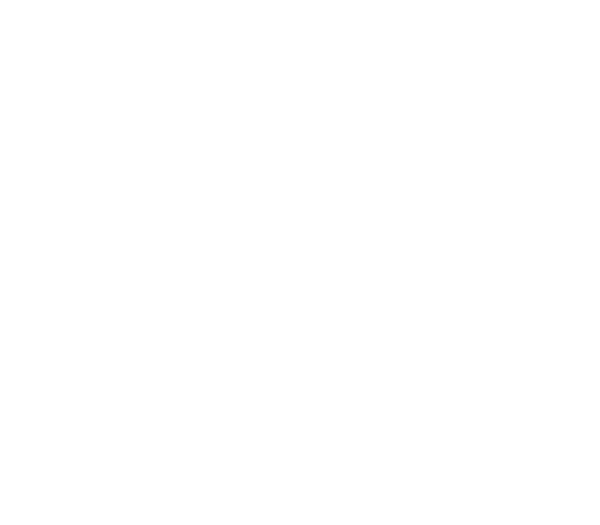

<IPython.core.display.Javascript object>


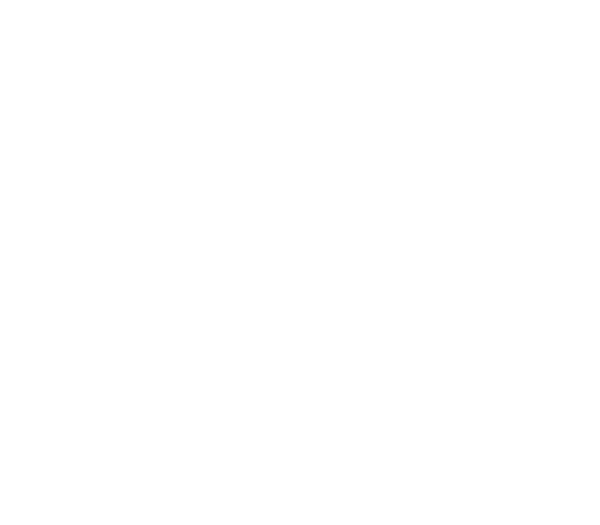

<IPython.core.display.Javascript object>


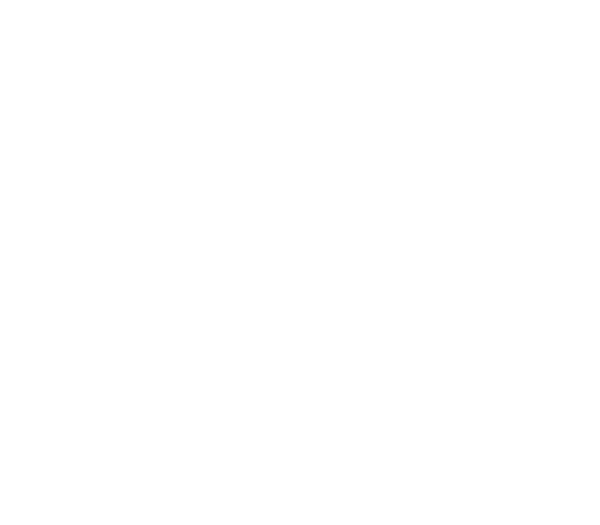

<IPython.core.display.Javascript object>


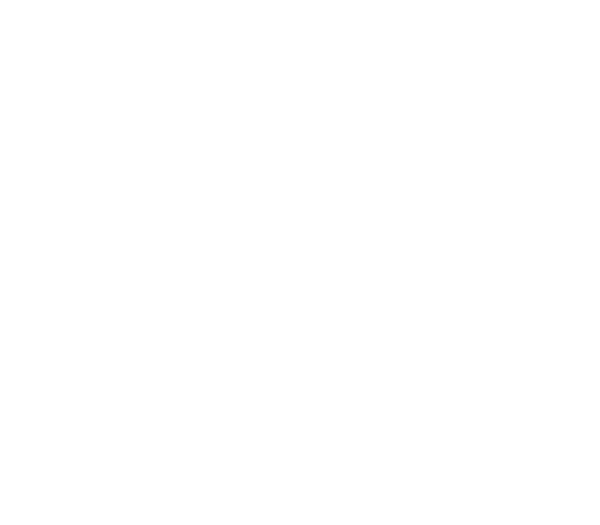

<IPython.core.display.Javascript object>


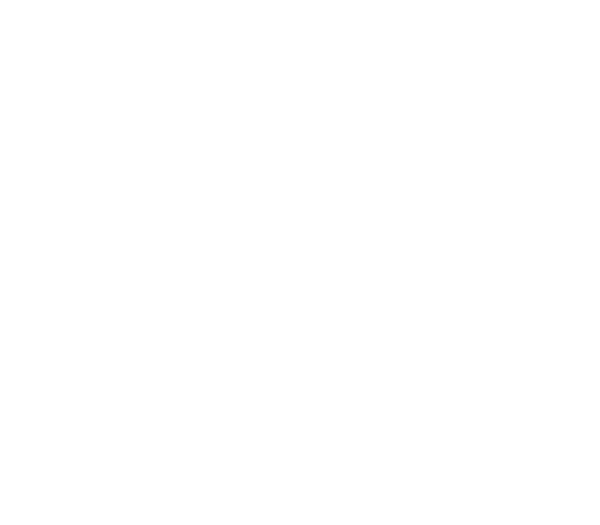

<IPython.core.display.Javascript object>


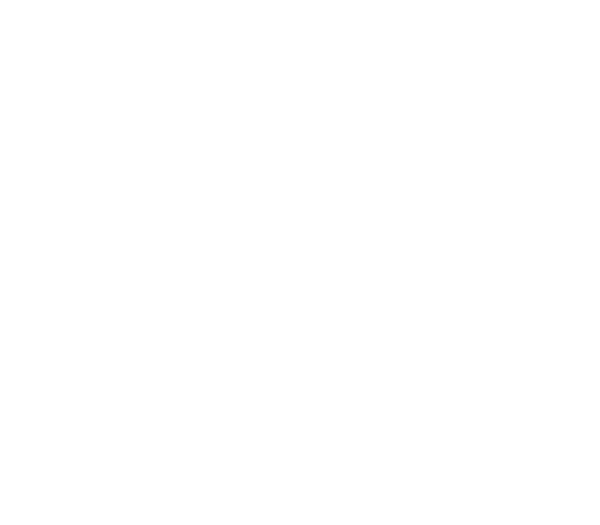

<IPython.core.display.Javascript object>


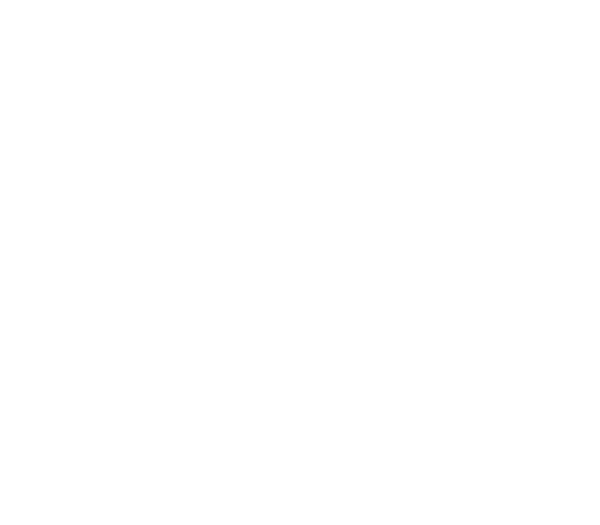

<IPython.core.display.Javascript object>


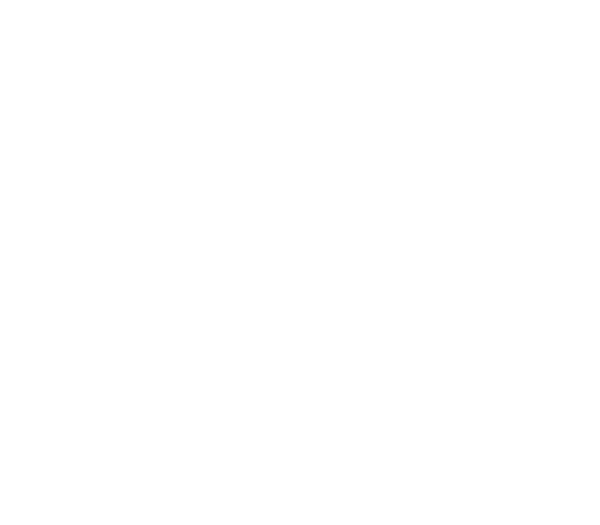

<IPython.core.display.Javascript object>


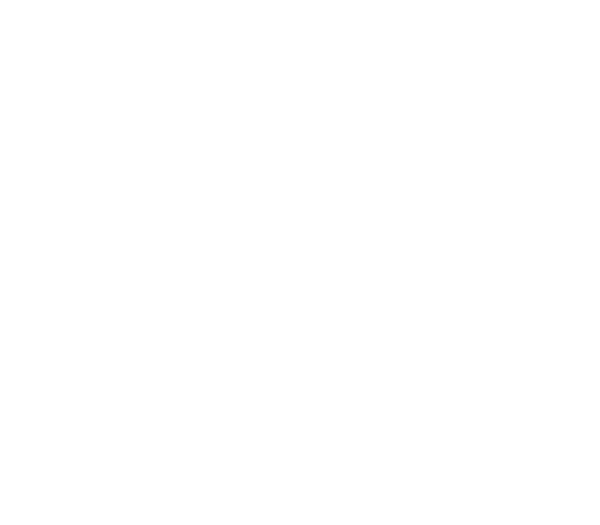

<IPython.core.display.Javascript object>


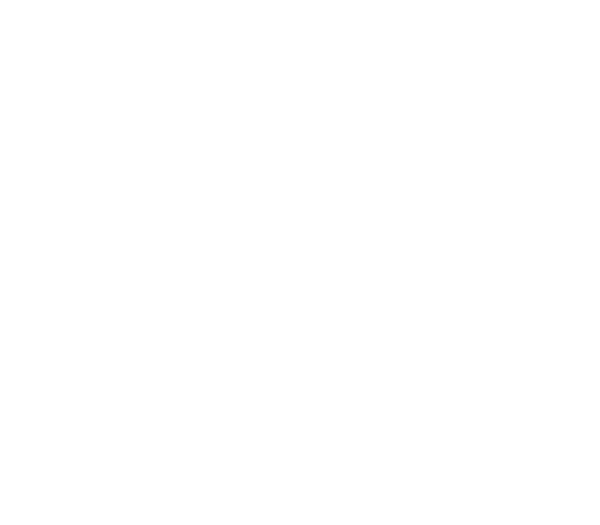

<IPython.core.display.Javascript object>


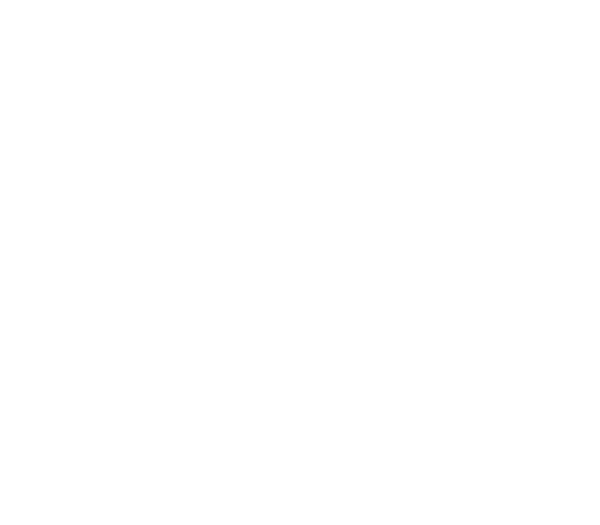

<IPython.core.display.Javascript object>


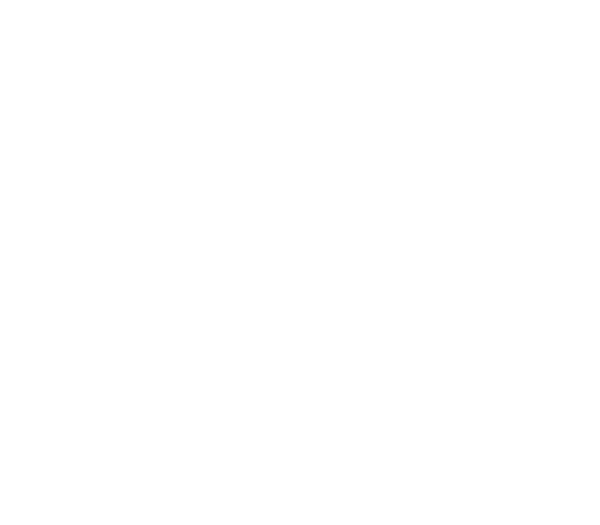

<IPython.core.display.Javascript object>


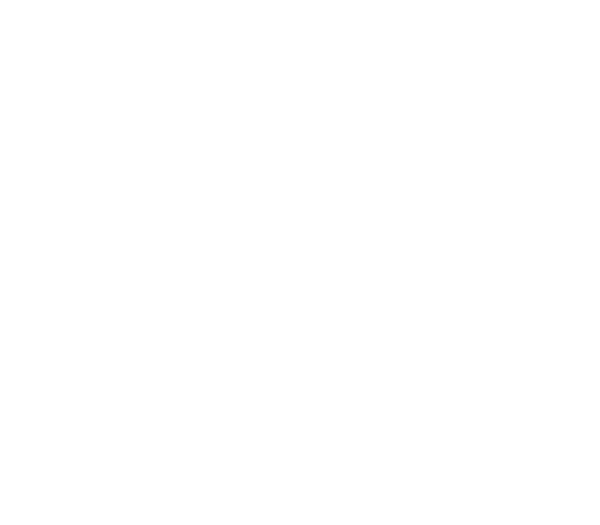

<IPython.core.display.Javascript object>


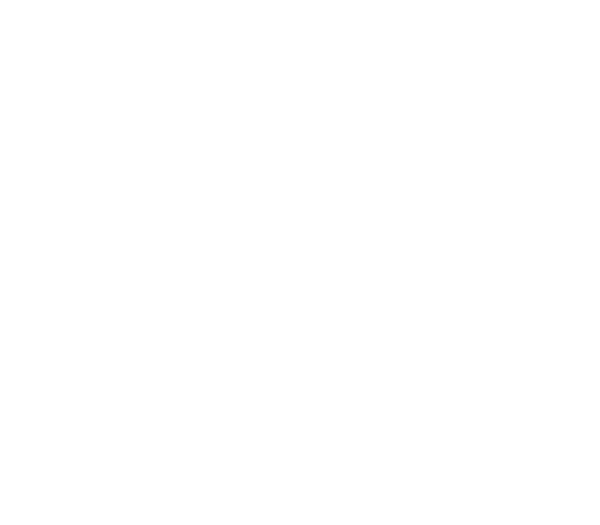

<IPython.core.display.Javascript object>


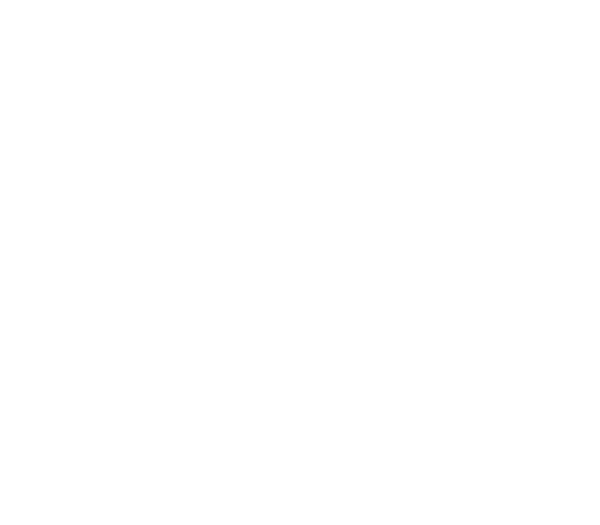

<IPython.core.display.Javascript object>


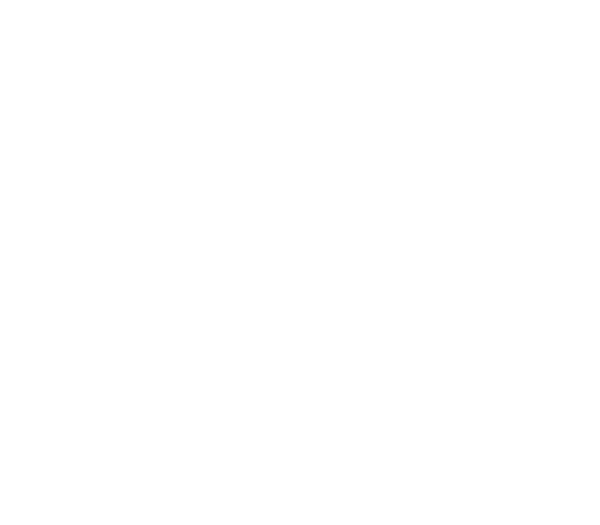

<IPython.core.display.Javascript object>


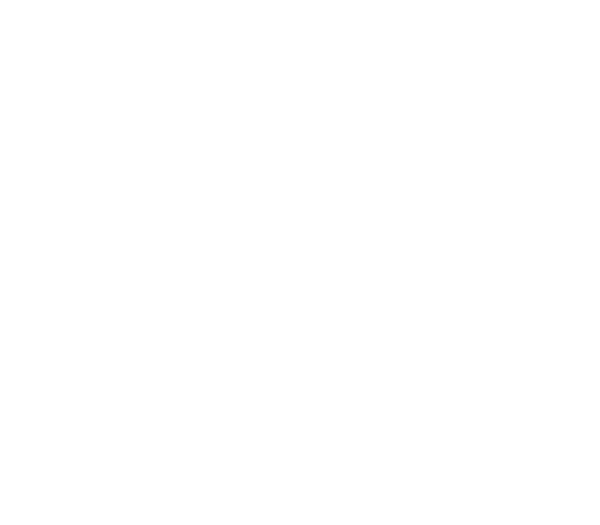

<IPython.core.display.Javascript object>


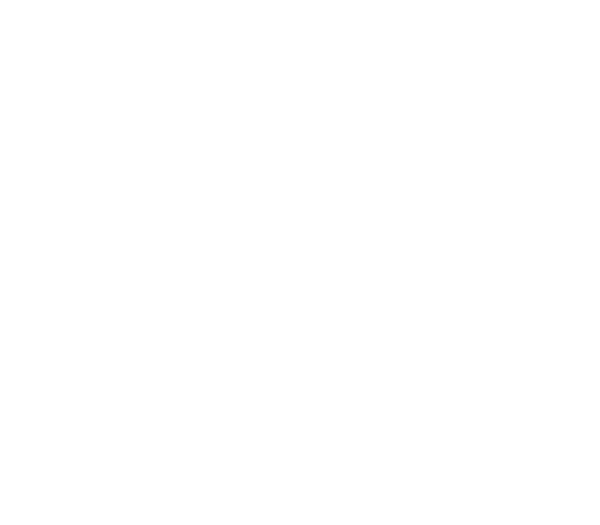

<IPython.core.display.Javascript object>


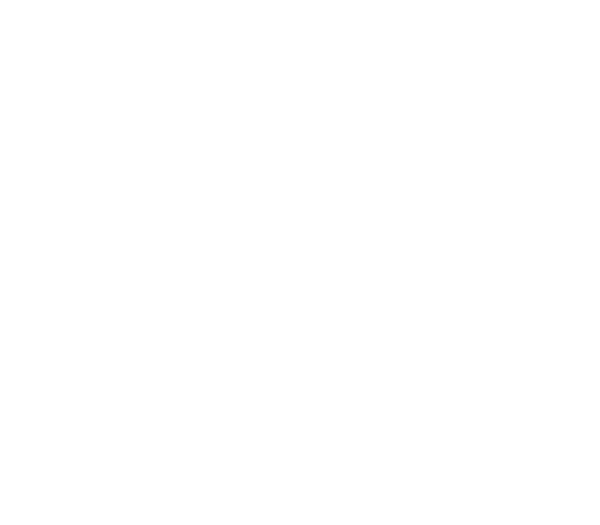

<IPython.core.display.Javascript object>


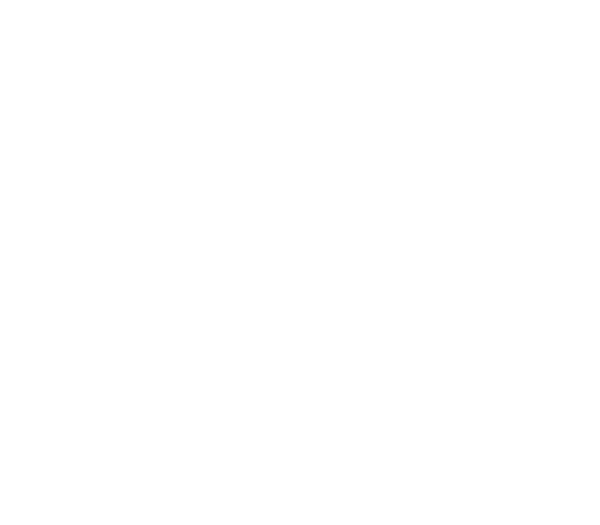

<IPython.core.display.Javascript object>


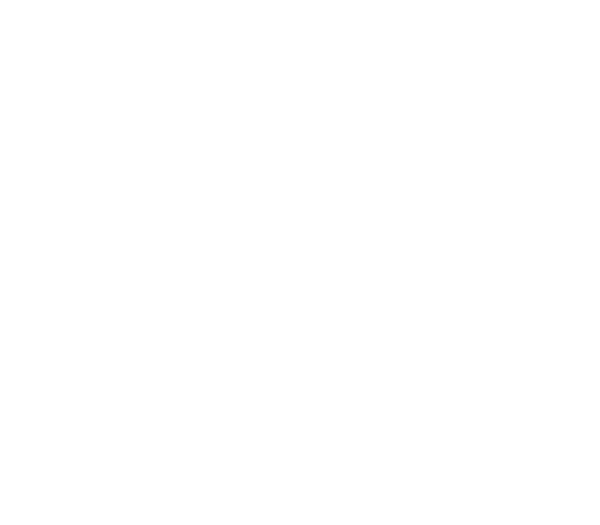

<IPython.core.display.Javascript object>


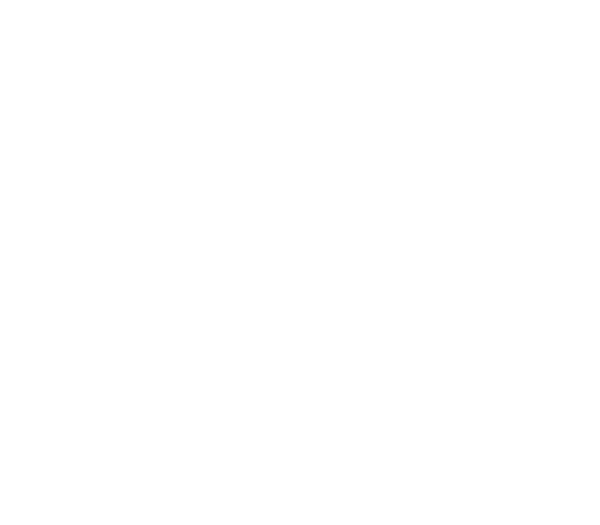

<IPython.core.display.Javascript object>


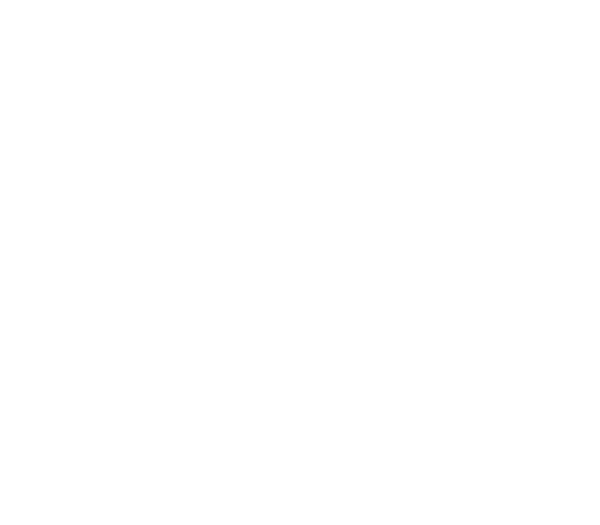

<IPython.core.display.Javascript object>


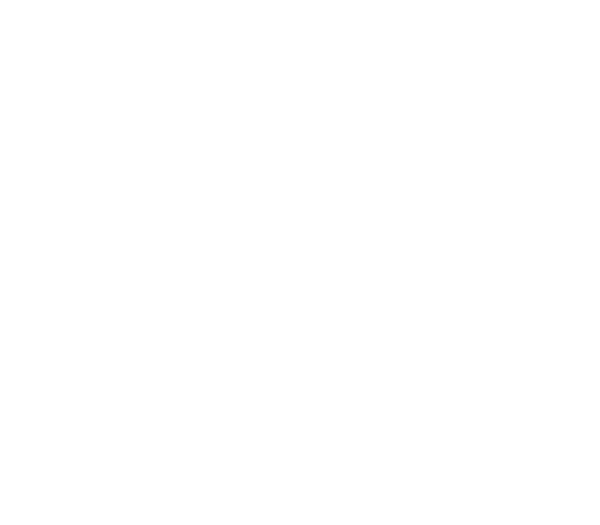

<IPython.core.display.Javascript object>


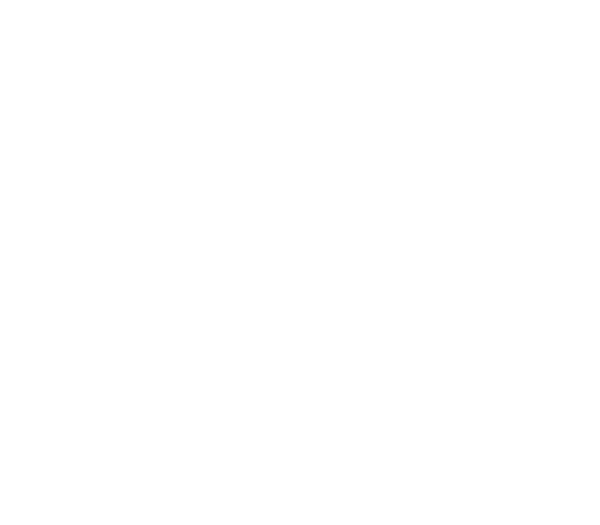

<IPython.core.display.Javascript object>


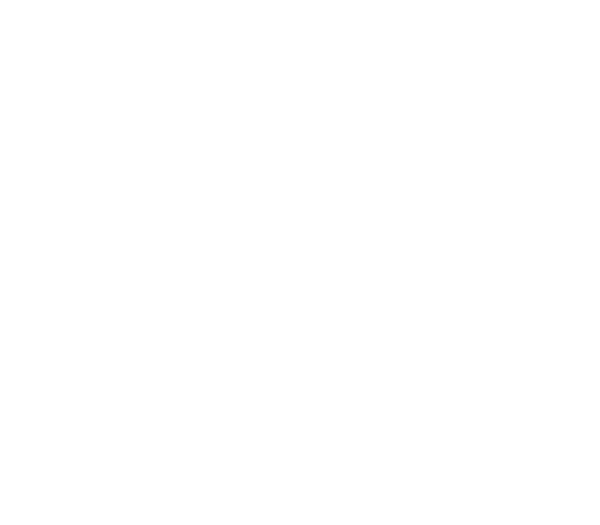

<IPython.core.display.Javascript object>


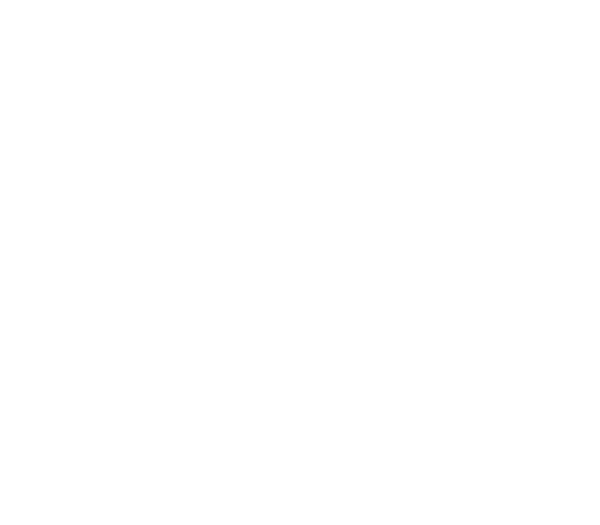

<IPython.core.display.Javascript object>


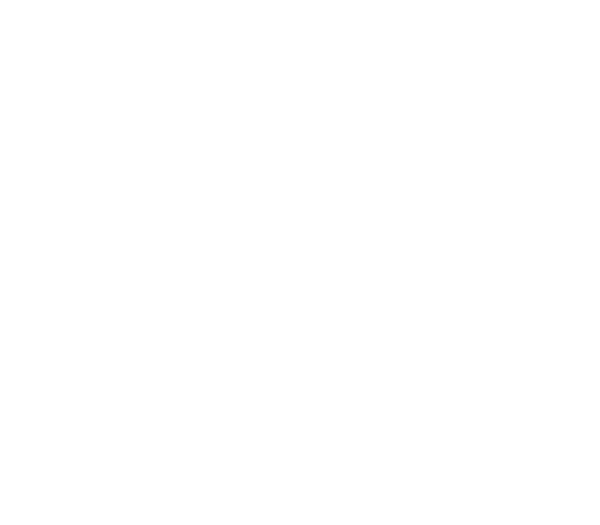

<IPython.core.display.Javascript object>


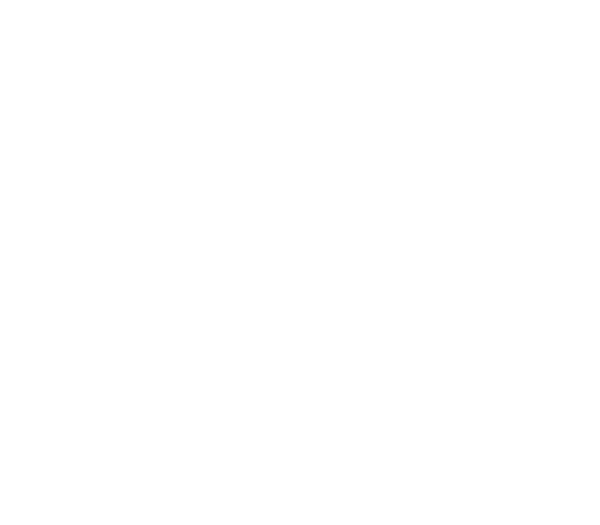

<IPython.core.display.Javascript object>


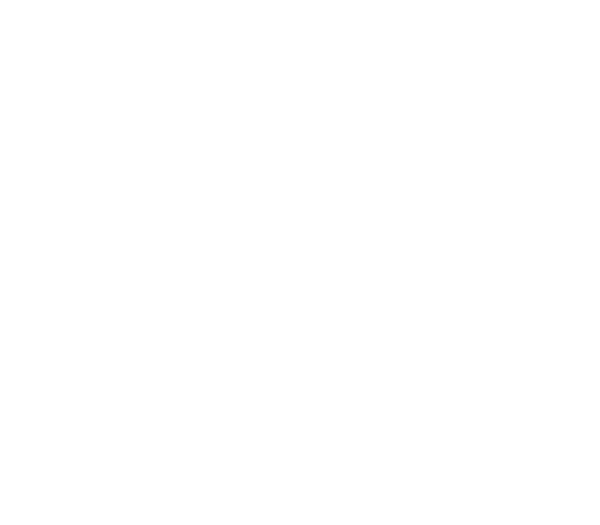

<IPython.core.display.Javascript object>


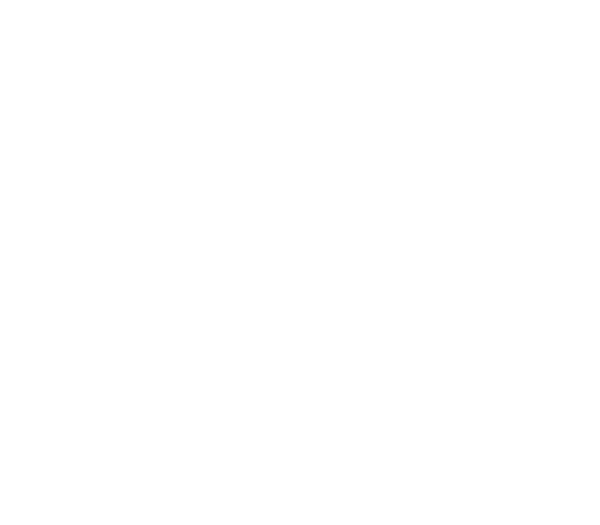

<IPython.core.display.Javascript object>


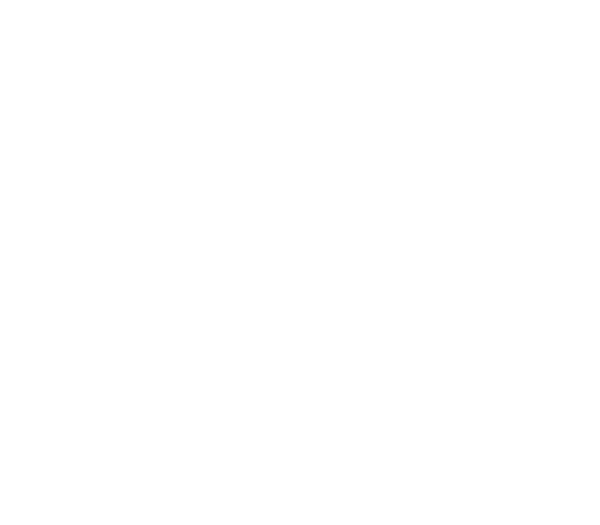

In [78]:
date = 20241028
ignore = range(189, 204)
data_range = [i for i in range(134, 195)]# if i not in ignore]
extra_info = "_wideTrapCooling"    # extra infor for saving, add _

odt_path = f"/home/bec_lab/Desktop/imgs/ODT/"
folder_path = odt_path + f"{date}{extra_info}/"

for shot in range(134, 204):
    pic = makeAPic(date, shot, num=0, multi_loop=0)
    cooling_depth = get_parameter(date, shot, "coolingdepth")
    
    fig, ax = plt.subplots(1, 1, figsize=(8,7))
    ax.imshow(pic, vmin=0, vmax=1.3, cmap='afmhot_r', interpolation='none', origin="lower", aspect='auto')
    ax.set_title(f"{cooling_depth = }")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.savefig(folder_path + f"{str(int(cooling_depth*10)).zfill(4)}{str(shot).zfill(4)}.png")
    plt.close()
    
    
# Make a movie?
movie = True
if movie: 
    img_array = []
    i = 0
    files = glob.glob(folder_path + '*.png')
    files.sort(reverse=True)

    for filename in files:
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)
        i += 1

    out = cv2.VideoWriter(odt_path + f"{date}.mp4", 0x7634706d, 10, size)
    for i in range(len(img_array)):
        out.write(img_array[i])

    out.release()

## Different scanning trap oscillation frequency

<IPython.core.display.Javascript object>


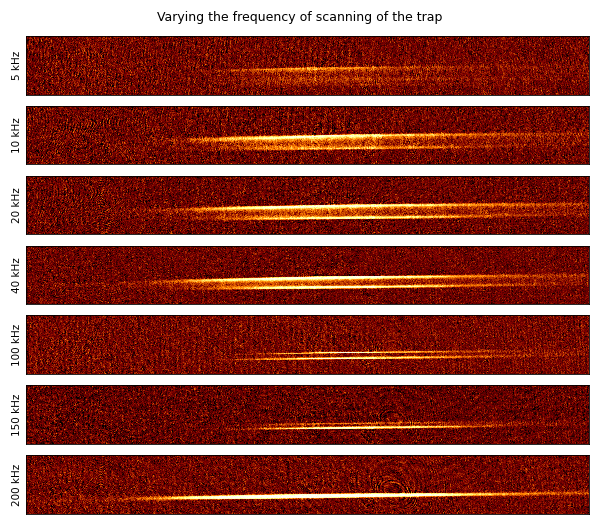

<ipython-input-77-c278b2696458>:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
<ipython-input-77-c278b2696458>:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [77]:
date = 20241028
data_range = [229, 210, 212, 216, 237, 239, 230 ]          
freqs = [5, 10, 20, 40, 100, 150, 200]
    
fig, ax = plt.subplots(7, 1, figsize=(8,7))

for i in range(len(data_range)):
    pic = makeAPic(date, data_range[i], num=0, multi_loop=0)
    pic = pic[975:1170, 500:]
    cooling_depth = get_parameter(date, shot, "coolingdepth")
    ax[i].imshow(pic, vmin=0, vmax=1.3, cmap='afmhot_r', interpolation='none', origin="lower", aspect='auto')
    ax[i].set_ylabel(f"{freqs[i]} kHz")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    plt.tight_layout()
    plt.suptitle(f"Varying the frequency of scanning of the trap")
    plt.tight_layout()
#     plt.savefig(f"/home/bec_lab/Desktop/imgs/ODT/20241028_wideTrapeCooling/{str(int(cooling_depth*10)).zfill(4)}{str(shot).zfill(4)}.png")
    plt.show()

## Trapping Frequency in MT

In [60]:
# Initial values
initial_fit_vals = {
    "offset": 0.,
    "amp_ov": 1.,
    "ang": 0,
    "center": (70, 840),
    "tfa": 1,
    "tfw": (20, 50),
    "ga": 1,
    "gw": (22, 100),
    "j_guess": 40 ,
    "axamp": 1,
    "x_shift": 0.0,
    "squeeze_par": 1.0,
}

<IPython.core.display.Javascript object>


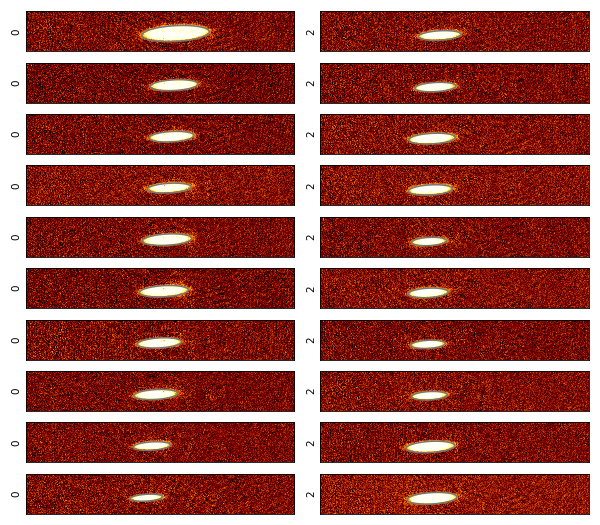

/home/bec_lab/python/BECViewer/pckg/fit/OAHDEV_functions.py:95: RuntimeWarning: invalid value encountered in divide
  pic = (atom - dark) / (flat - dark)


[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]


<ipython-input-32-c950d8034253>:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]


/home/bec_lab/python/BECViewer/pckg/fit/OAHDEV_functions.py:95: RuntimeWarning: divide by zero encountered in divide
  pic = (atom - dark) / (flat - dark)


[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]


In [32]:
date = 20241029
data_range = range(87, 108) 
time = range(0, 41, 2)

all_fits = []
fig, ax = plt.subplots(10, 2, figsize=(8,7))

i = 0
for j in range(20):
    t_mark = time[j]
    pic = makeAPic(date, data_range[j], num=0, multi_loop=0)
    pic = pic[975:1170, 500:]
    fit = fitting(pic, mode="gauss", init_guess=initial_fit_vals, normalize=False, invert=False, OAH=False)    
    all_fits.append(fit[-1].beta)
    if j >= 10:
        i = 1
        j -= 10
        
    ax[j][i].imshow(pic, vmin=0, vmax=1.3, cmap='afmhot_r', interpolation='none', origin="lower", aspect='auto')
    ax[j][i].contour(fit[1], levels=np.linspace(0, 3, 6), vmin=0, vmax=1.3, cmap='gray')
    ax[j][i].set_ylabel(f"{t_mark} ms")
    ax[j][i].set_xticks([])
    ax[j][i].set_yticks([])
    
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


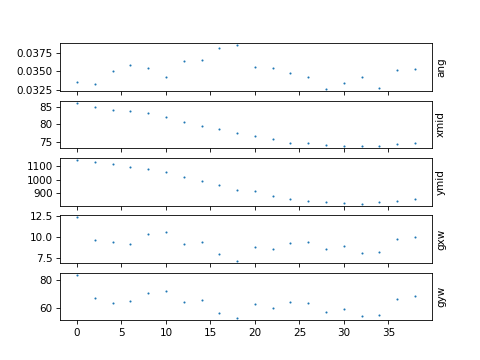

In [68]:
rshaped = np.array(all_fits).T
par_names = ['offset', 'ampl', 'ang', 'xmid', 'ymid', 'gamp', 'gxw', 'gyw']
time = range(0, 41, 2)

fig, ax = plt.subplots(5, 1, sharex=True)
ax[0].scatter(time[:-1], rshaped[2], s=1) # angle
ax[1].scatter(time[:-1], rshaped[3], s=1) # xmid
ax[2].scatter(time[:-1], rshaped[4], s=1) # ymid
ax[3].scatter(time[:-1], rshaped[6], s=1) # xmid
ax[4].scatter(time[:-1], rshaped[7], s=1) # ymid

ax[0].set_ylabel(par_names[2]) # angle
ax[1].set_ylabel(par_names[3]) # xmid
ax[2].set_ylabel(par_names[4]) # ymid
ax[3].set_ylabel(par_names[6]) # xmid
ax[4].set_ylabel(par_names[7]) # ymid

for a in ax:
    a.yaxis.set_label_position("right")


plt.show()

In [71]:
len(data_range)

17

In [95]:
date = 20241029
data_range = range(111, 128) 
time = range(0, 81, 5)

all_fits_2 = []
fig, ax = plt.subplots(8, 2, figsize=(8,7))

i = 0
for j in range(16):
    t_mark = time[j]
    pic = makeAPic(date, data_range[j], num=0, multi_loop=0)
    pic = pic[975:1170, 500:]
    fit = fitting(pic, mode="gauss", init_guess=initial_fit_vals, normalize=False, invert=False, OAH=False)    
    all_fits_2.append(fit[-1].beta)
    if j >= 8:
        i = 1
        j -= 8
        
    ax[j][i].imshow(pic, vmin=0, vmax=1.3, cmap='afmhot_r', interpolation='none', origin="lower", aspect='auto')
    ax[j][i].contour(fit[1], levels=np.linspace(0, 3, 6), vmin=0, vmax=1.3, cmap='gray')
    ax[j][i].set_ylabel(f"{t_mark} ms")
    ax[j][i].set_xticks([])
    ax[j][i].set_yticks([])
    
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]


<ipython-input-95-6651e9e3cb53>:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]
[  0.   1.   0.  70. 840.   1.  22. 100.]


/home/bec_lab/python/BECViewer/pckg/fit/OAHDEV_functions.py:95: RuntimeWarning: divide by zero encountered in divide
  pic = (atom - dark) / (flat - dark)


[  0.   1.   0.  70. 840.   1.  22. 100.]


In [78]:
import numpy as np
from scipy.optimize import curve_fit

def sinusoidal(x, A, f, phi, C):
    return A * np.sin(f * 2 * np.pi * x * 1e-3 + phi) + C

In [167]:
time = range(0, 81, 5)
rshaped = np.array(all_fits_2).T
par_names = ['angle', 'x-middle', 'y-middle', 'x-width', 'y-width']
rshaped = [rshaped[i] for i in [2, 3, 4,6, 7]]
time = time[:-1]


freq_guess=[30, 15, 15, 60, 60]
phas_guess=[np.pi, 0., 0., 0., 0.]


fig, ax = plt.subplots(5, 1, figsize=(8,8), sharex=True)

for i in range(5):
    ax[i].scatter(time, rshaped[i], s=3)

    dtmax = max(rshaped[i])
    dtmin = min(rshaped[i])
    initial_guess = [(dtmax-dtmin)/2, freq_guess[i], phas_guess[i], (dtmax+dtmin)/2]  # Initial guesses for A, f, phi, and C
    
    params, _ = curve_fit(sinusoidal, time, rshaped[i], p0=initial_guess)
    x_fit = np.linspace(np.min(time), np.max(time), 1000)
    A, fitted_frequency, phi, C = params
    y_fit = sinusoidal(x_fit, A, fitted_frequency, phi, C)
    y_guess = sinusoidal(x_fit, *initial_guess)
    
    # Extract the frequency from fitted parameters
    fitted_frequency = params[1]

    ax[i].plot(x_fit, y_fit, c='r', alpha=0.2, label=f"{round(fitted_frequency,2)} Hz") 
#     ax[i].plot(x_fit, y_guess, c='b', alpha=0.2) 
    ax[i].yaxis.set_label_position("right")
    ax[i].set_ylabel(f"{par_names[i]}")
    ax[i].legend(loc=1)
    
ax[i].set_xlabel("Time [ms]")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

## Let's go with the OAH images of the MT

### Preprocess Bimodal

In [11]:
# load all data and process OAH - 3m30s
all_angs = [OAH_full_process(20241029, 164, num, 0.000, "quad2")[2] for num in range(200)]
all_angs = [img[:, 1000:1800] for img in all_angs]

Number =  0
Indices provided: 
(188, 2548) (188, 2548)
Number =  1
Indices provided: 
(188, 2548) (188, 2548)
Number =  2
Indices provided: 
(188, 2548) (188, 2548)
Number =  3
Indices provided: 
(188, 2548) (188, 2548)
Number =  4
Indices provided: 
(188, 2548) (188, 2548)
Number =  5
Indices provided: 
(188, 2548) (188, 2548)
Number =  6
Indices provided: 
(188, 2548) (188, 2548)
Number =  7
Indices provided: 
(188, 2548) (188, 2548)
Number =  8
Indices provided: 
(188, 2548) (188, 2548)
Number =  9
Indices provided: 
(188, 2548) (188, 2548)
Number =  10
Indices provided: 
(188, 2548) (188, 2548)
Number =  11
Indices provided: 
(188, 2548) (188, 2548)
Number =  12
Indices provided: 
(188, 2548) (188, 2548)
Number =  13
Indices provided: 
(188, 2548) (188, 2548)
Number =  14
Indices provided: 
(188, 2548) (188, 2548)
Number =  15
Indices provided: 
(188, 2548) (188, 2548)
Number =  16
Indices provided: 
(188, 2548) (188, 2548)
Number =  17
Indices provided: 
(188, 2548) (188, 2548)
Nu

Number =  146
Indices provided: 
(188, 2548) (188, 2548)
Number =  147
Indices provided: 
(188, 2548) (188, 2548)
Number =  148
Indices provided: 
(188, 2548) (188, 2548)
Number =  149
Indices provided: 
(188, 2548) (188, 2548)
Number =  150
Indices provided: 
(188, 2548) (188, 2548)
Number =  151
Indices provided: 
(188, 2548) (188, 2548)
Number =  152
Indices provided: 
(188, 2548) (188, 2548)
Number =  153
Indices provided: 
(188, 2548) (188, 2548)
Number =  154
Indices provided: 
(188, 2548) (188, 2548)
Number =  155
Indices provided: 
(188, 2548) (188, 2548)
Number =  156
Indices provided: 
(188, 2548) (188, 2548)
Number =  157
Indices provided: 
(188, 2548) (188, 2548)
Number =  158
Indices provided: 
(188, 2548) (188, 2548)
Number =  159
Indices provided: 
(188, 2548) (188, 2548)
Number =  160
Indices provided: 
(188, 2548) (188, 2548)
Number =  161
Indices provided: 
(188, 2548) (188, 2548)
Number =  162
Indices provided: 
(188, 2548) (188, 2548)
Number =  163
Indices provided:

In [54]:
# Fit everything 20 mins, if good guesses. 
initial_fit_vals = {
    "offset": 0.,
    "amp_ov": 1.,
    "ang": 0,
    "center": (70, 340),
    "tfa": 1,
    "tfw": (20, 50),
    "ga": 1,
    "gw": (22, 100),
    "j_guess": 40 ,
    "axamp": 1,
    "x_shift": 0.0,
    "squeeze_par": 1.0,
}

i = 0
all_fits =  []
for pic in all_angs:
    clear_output()
    print(i)
    
    temp_fit = fitting(pic, mode="bimodal", init_guess=initial_fit_vals, normalize=False, invert=False, OAH=True)
    
    
    # if the max value of the fit is above 1, then use that fit as an initial guess for the next fit
    if temp_fit[1].max() > 1:
        initial_fit_vals = {
            "offset": temp_fit[-1].beta[0],
            "amp_ov": temp_fit[-1].beta[1],
            "ang": temp_fit[-1].beta[2],
            "center": (temp_fit[-1].beta[3], temp_fit[-1].beta[4]),
            "tfa": temp_fit[-1].beta[5],
            "tfw": (temp_fit[-1].beta[6], temp_fit[-1].beta[7]),
            "ga": temp_fit[-1].beta[8],
            "gw": (temp_fit[-1].beta[9], temp_fit[-1].beta[10]),
            "j_guess": 40 ,
            "axamp": 1,
            "x_shift": 0.0,
            "squeeze_par": 1.0,
        }
        
    # otherwise set it to the initial guess, and fit again - give two shots to every frame
    else: 
        initial_fit_vals = {
            "offset": 0.,
            "amp_ov": 1.,
            "ang": 0,
            "center": (70, 340),
            "tfa": 1,
            "tfw": (20, 50),
            "ga": 1,
            "gw": (22, 100),
            "j_guess": 40 ,
            "axamp": 1,
            "x_shift": 0.0,
            "squeeze_par": 1.0,
        }
        temp_fit = fitting(pic, mode="bimodal", init_guess=initial_fit_vals, normalize=False, invert=False, OAH=True)

    
    all_fits.append(temp_fit)
    i+=1

199
{'offset': -0.014753547798160582, 'amp_ov': 518.8264109618458, 'ang': 0.016084816619231064, 'center': (56.31873098006075, 412.6833776355998), 'tfa': 0.0003436683150642045, 'tfw': (14.012192774466767, 122.3588631152863), 'ga': 0.0030404926637491226, 'gw': (2.2384391915293116, 13.014395628261177), 'j_guess': 40, 'axamp': 1, 'x_shift': 0.0, 'squeeze_par': 1.0}
[-1.47535478e-02  5.18826411e+02  1.60848166e-02  5.63187310e+01
  4.12683378e+02  3.43668315e-04  1.40121928e+01  1.22358863e+02
  3.04049266e-03  2.23843919e+00  1.30143956e+01]


In [185]:
np.save("all_fits_bi",  np.array(all_fits, dtype=object))
np.save("all_angs", np.array(all_angs, dtype=object))

### Preprocess Gaussian 

In [18]:
# load all data and process OAH - 3m30s
all_angs = [OAH_full_process(20241029, 164, num, 0.000, "quad2")[2] for num in range(200)]
all_angs = [img[:, 1000:1800] for img in all_angs]

Number =  0
Indices provided: 
(188, 2548) (188, 2548)
Number =  1
Indices provided: 
(188, 2548) (188, 2548)
Number =  2
Indices provided: 
(188, 2548) (188, 2548)
Number =  3
Indices provided: 
(188, 2548) (188, 2548)
Number =  4
Indices provided: 
(188, 2548) (188, 2548)
Number =  5
Indices provided: 
(188, 2548) (188, 2548)
Number =  6
Indices provided: 
(188, 2548) (188, 2548)
Number =  7
Indices provided: 
(188, 2548) (188, 2548)
Number =  8
Indices provided: 
(188, 2548) (188, 2548)
Number =  9
Indices provided: 
(188, 2548) (188, 2548)
Number =  10
Indices provided: 
(188, 2548) (188, 2548)
Number =  11
Indices provided: 
(188, 2548) (188, 2548)
Number =  12
Indices provided: 
(188, 2548) (188, 2548)
Number =  13
Indices provided: 
(188, 2548) (188, 2548)
Number =  14
Indices provided: 
(188, 2548) (188, 2548)
Number =  15
Indices provided: 
(188, 2548) (188, 2548)
Number =  16
Indices provided: 
(188, 2548) (188, 2548)
Number =  17
Indices provided: 
(188, 2548) (188, 2548)
Nu

Number =  146
Indices provided: 
(188, 2548) (188, 2548)
Number =  147
Indices provided: 
(188, 2548) (188, 2548)
Number =  148
Indices provided: 
(188, 2548) (188, 2548)
Number =  149
Indices provided: 
(188, 2548) (188, 2548)
Number =  150
Indices provided: 
(188, 2548) (188, 2548)
Number =  151
Indices provided: 
(188, 2548) (188, 2548)
Number =  152
Indices provided: 
(188, 2548) (188, 2548)
Number =  153
Indices provided: 
(188, 2548) (188, 2548)
Number =  154
Indices provided: 
(188, 2548) (188, 2548)
Number =  155
Indices provided: 
(188, 2548) (188, 2548)
Number =  156
Indices provided: 
(188, 2548) (188, 2548)
Number =  157
Indices provided: 
(188, 2548) (188, 2548)
Number =  158
Indices provided: 
(188, 2548) (188, 2548)
Number =  159
Indices provided: 
(188, 2548) (188, 2548)
Number =  160
Indices provided: 
(188, 2548) (188, 2548)
Number =  161
Indices provided: 
(188, 2548) (188, 2548)
Number =  162
Indices provided: 
(188, 2548) (188, 2548)
Number =  163
Indices provided:

In [19]:
# Fit everything 20 mins, if good guesses. 
initial_fit_vals = {
    "offset": 0.,
    "amp_ov": 1.,
    "ang": 0,
    "center": (70, 340),
    "tfa": 1,
    "tfw": (20, 50),
    "ga": 1,
    "gw": (22, 100),
    "j_guess": 40 ,
    "axamp": 1,
    "x_shift": 0.0,
    "squeeze_par": 1.0,
}

i = 0
all_fits_g =  []
for pic in all_angs:
    clear_output()
    print(i)
    
    temp_fit = fitting(pic, mode="gauss", init_guess=initial_fit_vals, normalize=False, invert=False, OAH=True)
    
    # if the max value of the fit is above 1, then use that fit as an initial guess for the next fit
    if temp_fit[1].max() > 1:
        initial_fit_vals = {
            "offset": temp_fit[-1].beta[0],
            "amp_ov": temp_fit[-1].beta[1],
            "ang": temp_fit[-1].beta[2],
            "center": (temp_fit[-1].beta[3], temp_fit[-1].beta[4]),
            "tfa": 0,
            "tfw": (0, 0),
            "ga": temp_fit[-1].beta[5],
            "gw": (temp_fit[-1].beta[6], temp_fit[-1].beta[7]),
            "j_guess": 40 ,
            "axamp": 1,
            "x_shift": 0.0,
            "squeeze_par": 1.0,
        }
        
    # otherwise set it to the initial guess, and fit again - give two shots to every frame
    else: 
        initial_fit_vals = {
            "offset": 0.,
            "amp_ov": 1.,
            "ang": 0,
            "center": (70, 340),
            "tfa": 1,
            "tfw": (20, 50),
            "ga": 1,
            "gw": (22, 100),
            "j_guess": 40 ,
            "axamp": 1,
            "x_shift": 0.0,
            "squeeze_par": 1.0,
        }
        temp_fit = fitting(pic, mode="gauss", init_guess=initial_fit_vals, normalize=False, invert=False, OAH=True)

    all_fits_g.append(temp_fit)
    i+=1

199
[-1.31726990e-02  2.51374268e-01  8.36148884e-03  5.63363926e+01
  4.12755462e+02  6.15365658e+00  2.73079202e+00  1.68726481e+01]


In [20]:
np.save("all_fits_g",  np.array(all_fits_g, dtype=object))

### Just Load the data

In [16]:
all_angs = np.load("all_angs.npy", allow_pickle=True)

In [21]:
mode = "gauss"
# mode = "bimodal" #"gauss"

if mode == "bimodal":
    all_fits = np.load("all_fits_bi.npy", allow_pickle=True)
    
elif mode == "gauss":
    all_fits = np.load("all_fits_g.npy", allow_pickle=True)


### PLOTTING

In [22]:
fig, ax = plt.subplots(20, 3, sharex=True, sharey=True, figsize=(6, 20))
for i in range(20):
    pic = all_fits[i*4][0]
    fit = all_fits[i*4][1]
    fit_guess = all_fits[i*4][2]
    ax[i][0].imshow(pic, vmin=-2, vmax=2, cmap='afmhot_r', interpolation='none', origin="lower")
    ax[i][1].imshow(fit, vmin=-2, vmax=2, cmap='afmhot_r', interpolation='none', origin="lower")
    ax[i][2].imshow(fit_guess, vmin=-2, vmax=2, cmap='afmhot_r', interpolation='none', origin="lower")
    ax[i][0].set_ylabel(i)
    ax[i][2].set_ylabel(round(all_fits[i][1].max(), 3))
    ax[i][2].yaxis.set_label_position("right")
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])    
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])
    
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

In [36]:
p0s

[[0.0191784253, 107.879436, -3.57036624, 0.0350181283],
 [7.77268416, 108.07034073, 1.39878915, 63.8775174],
 [-19.70403856, 15.03655144, 0.57304846, 428.62962621],
 array([ 2.44164858e-02,  1.07836225e+02, -3.43559200e+00,  3.48641753e-02]),
 array([  7.78501859, 108.10074761,   1.39158394,  64.05843912]),
 array([-19.78300512,  15.0501945 ,   0.57252117, 428.75054648]),
 array([ 2.47024980e-02,  1.07484456e+02, -4.84705039e+00,  2.79827667e+00]),
 array([9.25614795e-02, 1.07769537e+02, 2.34531830e+00, 1.80633513e+01])]

<IPython.core.display.Javascript object>


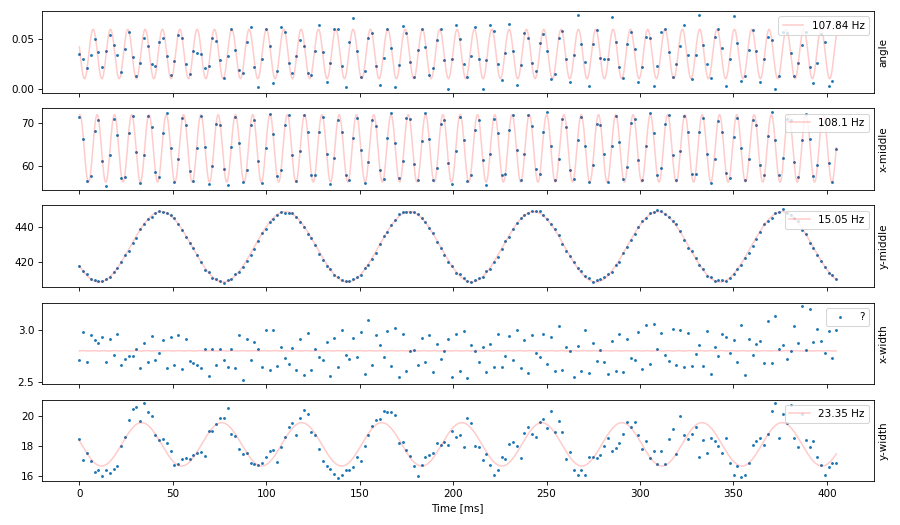

In [72]:
import numpy as np
from scipy.optimize import curve_fit

def sinusoidal(x, A, f, phi, C):
    return A * np.sin(f * 2 * np.pi * x * 1e-3 + phi) + C

fitted_vars = [el[-1].beta for el in all_fits]
time = np.linspace(0, 405, 200)
rshaped = np.array(fitted_vars).T

par_names = ['angle', 'x-middle', 'y-middle', 'x-width', 'y-width', 'G x-width', 'G y-width']
rshaped = [rshaped[i] for i in [2, 3, 4, 6, 7]]#, 9, 10]]

# Correct data for the misfits at indx 24 and 124
# Make it be average of the two neighbouring values
for ind in [31, 138]:
    for line in rshaped:
        line[ind] = 1/2 * (line[ind-1] + line[ind+1])

        
# coff = 40
# time = time[:coff]
# rshaped = [el[:coff] for el in rshaped]


p0s = [
    [ 1.91784253e-02,  107.879436, -3.57036624e+00,  3.50181283e-02],
    [  7.77268416, 108.07034073,   1.39878915,  63.8775174 ],
    [-19.70403856,  15.03655144,   0.57304846, 428.62962621],
    [-(rshaped[3].max() - rshaped[3].min())/3,  175.03655144,   2.57304846, (rshaped[3].max() + rshaped[3].min())/2],
    [-(rshaped[4].max() - rshaped[4].min())/2,  25.03655144,   0.57304846, (rshaped[4].max() + rshaped[4].min())/2],
]


fig, ax = plt.subplots(5, 1, figsize=(12,7), sharex=True)

for i in range(5):
    ax[i].scatter(time, rshaped[i], s=3)
    
    params, _ = curve_fit(sinusoidal, time, rshaped[i], p0=p0s[i])
    A, fitted_frequency, phi, C = params
    x_fit = np.linspace(np.min(time), np.max(time), 1000)
    y_fit = sinusoidal(x_fit, A, fitted_frequency, phi, C)
    y_guess = sinusoidal(x_fit, *p0s[i])
    ax[i].plot(x_fit, y_fit, c='r', alpha=0.2, label=f"{round(fitted_frequency ,2)} Hz") 
#     ax[i].plot(x_fit, y_guess, c='b', alpha=0.2) 
    
    ax[i].yaxis.set_label_position("right")
    ax[i].set_ylabel(f"{par_names[i]}")
    ax[i].legend(loc=1)

ax[3].legend(labels=["?"])
ax[i].set_xlabel("Time [ms]")
plt.tight_layout()
plt.show()

### Dynamic properties calculations

In [77]:
fit_results = np.array(fitted_vars)

wavelength = 589e-9
detuning = 35
prefactor = 1*(1 + 4 * (float(detuning) ** 2)) * 2 * np.pi / (3 * (float(wavelength) ** 2)) * 18. / 5.
pixelsize = 2.47148288973384e-06 

to_physical = np.array([1., 1., 1., pixelsize, pixelsize, prefactor, pixelsize, pixelsize, prefactor, pixelsize, pixelsize])
all_physical = [fit_results[i] * to_physical[:8] for i in range(200) if i not in [31, 138]]

fx = 108
fz = 15
tof = 0


if mode == "bimodal":
    ntfs = [2. * np.pi / 5. * phys_results[5] * phys_results[6] * phys_results[7] for phys_results in all_physical]
    ntherms= [2 * np.pi * phys_results[8] * phys_results[9] * phys_results[10] for phys_results in all_physical]
    txs = [1 / kB * m / 1 * (fx * np.pi * 2 * phys_results[9]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2) for phys_results in all_physical]
    tzs = [1 / kB * m / 1 * (fz * np.pi * 2 * phys_results[10]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2) for phys_results in all_physical]
    muxs = [m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2) for phys_results in all_physical]
    muzs = [m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2) for phys_results in all_physical]
    # muns= [1.47708846953 * np.power(ntf * asc / (np.sqrt(hb / (m * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.)))), 2. / 5.) * hb * np.power(8 * np.pi ** 3 * fx ** 2 * fz, 1. / 3.) for phys_results in all_physical]
    ntotal = np.array(ntherms) + np.array(ntfs)

elif mode == "gauss":
    ntherms = [2 * np.pi * phys_results[5] * phys_results[6] * phys_results[7] for phys_results in all_physical]
    txs = [1 / kB * m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2) for phys_results in all_physical]
    tzs = [1 / kB * m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2) for phys_results in all_physical]
    muxs = [m / 1 * (fx * np.pi * 2 * phys_results[6]) ** 2 / (1 + (tof * fx * np.pi * 2) ** 2) for phys_results in all_physical]
    muzs = [m / 1 * (fz * np.pi * 2 * phys_results[7]) ** 2 / (1 + (tof * fz * np.pi * 2) ** 2) for phys_results in all_physical]


In [78]:
fig, ax = plt.subplots(6, figsize=(9, 8), sharex=True)

data_sets = [ntherms, txs, tzs, muxs, muzs, ntotal]
data_sets_names = ["ntherms", "txs", "tzs", "muxs", "muzs", "ntotal"]

for i in range(6):
    ax[i].plot(data_sets[i])
    ax[i].set_title(data_sets_names[i])

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>

## IR Trap Potential When Scanning

We took images at different frequencies, let's check how the trap looks like. 

In [666]:
md = "ir"

if md == "focus": 
    image_folder = "/home/bec_lab/Desktop/imgs/ODT/ODT_scan_profile/focused/"
    cut = [422, 502, 620, 720]
    lc = 41
    
elif md == "nofocus":
    image_folder = "/home/bec_lab/Desktop/imgs/ODT/ODT_scan_profile/unfocused/"
    cut = [410, 490, 600, 700]
    lc = 40
    
elif md =="ir":
    image_folder = "/home/bec_lab/Desktop/imgs/ODT/ODT_scan_profile/odt_ir/"
    cut = [380, 460, 550, 650]
    lc = 40


In [667]:
# Load images into a list
images = []
names = []
for filename in sorted(os.listdir(image_folder), key=lambda x: int(x.split('.')[0])):
    if filename.endswith('.png'):
        img_path = os.path.join(image_folder, filename)
        img = Image.open(img_path).convert("L") # load as grayscale
        img = np.array(img)                     # make an array
        img = rotate(img, -4,  mode='reflect')  # rotate
        images.append(img)                      # append
        names.append(filename.split('.')[0])

# Function to add suffix
def format_with_suffix(number_str):
    number = int(number_str)
    if number >= 1_000:
        return f"{number // 1_000} k"      # Thousands
    else:
        return str(number)                # Less than a thousand remains unchanged
    

<IPython.core.display.Javascript object>


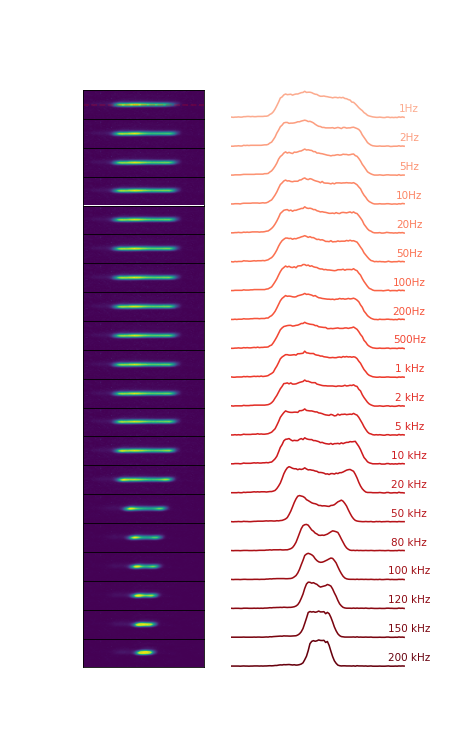

In [669]:
colormap = plt.cm.Reds  # You can change 'viridis' to any other colormap
n_shots = len(images)
fig, ax = plt.subplots(n_shots, 2, figsize=(6, 10), sharex=True)
for i in range(n_shots):
    ax[i][0].imshow(images[i][cut[0]:cut[1], cut[2]:cut[3]], aspect=0.3)
    ax[i][1].plot(images[i][cut[0]+lc, cut[2]:cut[3]], c=colormap(0.3+0.7*(i/19)))
#     ax[i][1].set_ylim([-50, 300])
    ax[i][0].set_yticks([])
    ax[i][1].set_yticks([])
    ax[i][0].set_xticks([])
    ax[i][1].set_xticks([])
    # Hide all spines
    for spine in ax[i][1].spines.values():
        spine.set_visible(False)

    ax[i][1].set_ylabel(f"{format_with_suffix(names[i])}Hz", rotation=0, color=colormap(0.3+0.7*(i/19)))
    ax[i][1].yaxis.set_label_position("right")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
ax[0][0].axhline(lc, ls='--', alpha=0.2, c='r') 

# plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


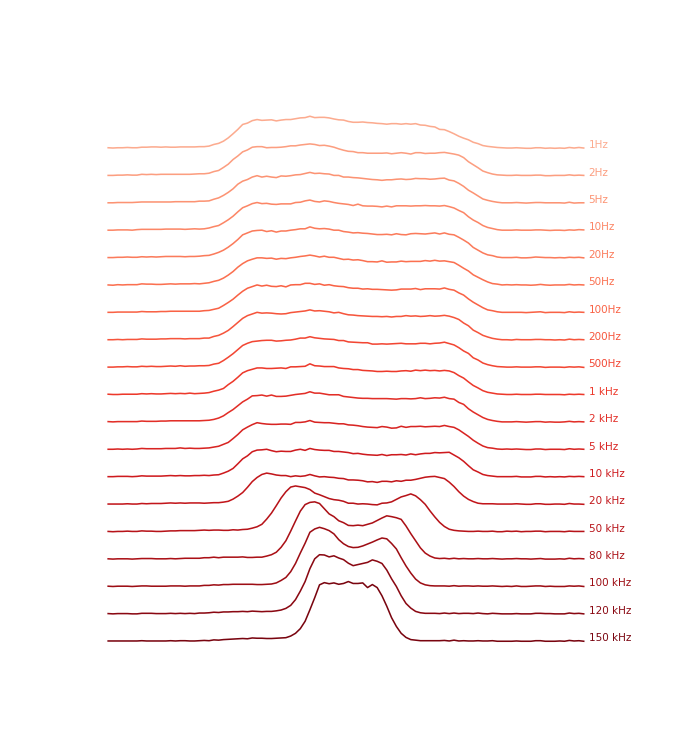

In [362]:
fig, ax = plt.subplots(1, 1, figsize=(9, 10), sharex=True)

for i in range(n_shots-1):
    ax.plot(np.array(images[i][cut[0]+lc, cut[2]:cut[3]], dtype=int) - 100*i, c=colormap(0.3+0.7*(i/19)))
    
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text((cut[3]-cut[2]), -100 * i, f"{format_with_suffix(names[i])}Hz", rotation=0, color=colormap(0.3+0.7*(i/19)))

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

## Make a custom scanning trap that will fix this

<IPython.core.display.Javascript object>


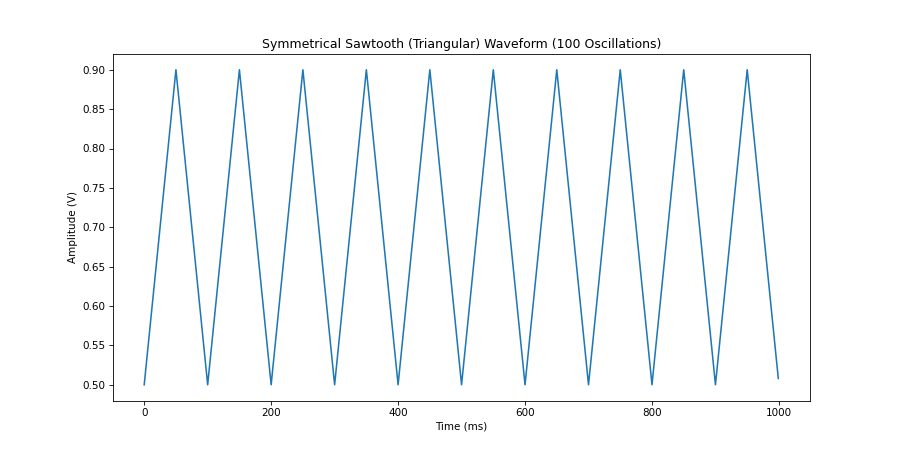

In [678]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the sawtooth wave
frequency = 10_000  # Frequency of the waveform in Hz
sample_rate = 1_000_000  # Sample rate in samples per second
duration = 1 / frequency  # Duration of one period (since f = 1 / T)
num_points = int(sample_rate * duration)  # Total points for one waveform cycle
min_value = 0.5  # Minimum voltage level
max_value = 0.9  # Maximum voltage level

# To create a symmetrical waveform, we'll make a triangular waveform, where the signal ramps up to the maximum value
# and then ramps down to the minimum in each cycle, giving it a symmetrical "sawtooth" appearance.
num_oscillations = 10

# Generate a single symmetric (triangular) waveform cycle
x_half = np.linspace(0, 1, num_points // 2, endpoint=False)  # Half cycle for ramp up
y_up = min_value + (max_value - min_value) * x_half  # Ramp up
y_down = max_value - (max_value - min_value) * x_half  # Ramp down

# Concatenate up and down ramps for a full symmetric cycle
y_symmetric = np.concatenate([y_up, y_down])
y_repeated_symmetric = np.tile(y_symmetric, num_oscillations)
t_symmetric = np.linspace(0, num_oscillations * duration, num_oscillations * len(y_symmetric), endpoint=False)
        
# Plot the symmetric waveform
plt.figure(figsize=(12, 6))
plt.plot(t_symmetric*1e6, y_repeated_symmetric)
plt.title("Symmetrical Sawtooth (Triangular) Waveform (100 Oscillations)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (V)")
plt.show()


<IPython.core.display.Javascript object>


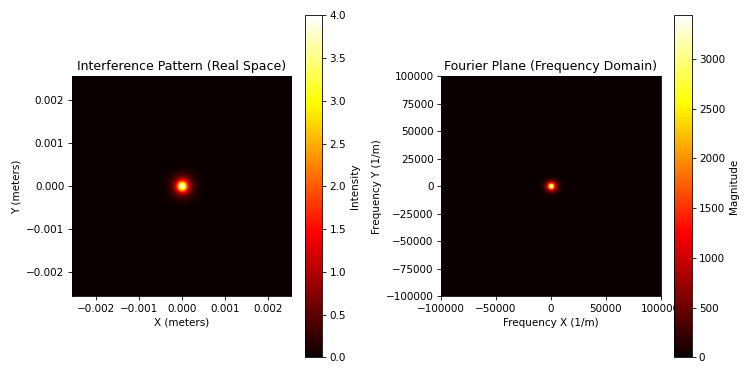

In [681]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
image_size = 512           # Size of the image (NxN pixels)
beam_intensity = 1.0       # Intensity of each beam
wavelength = 0.5e-6        # Wavelength of light (meters)
pixel_size = 10e-6         # Size of each pixel (meters)

# Beam parameters
divergence1 = 0.02         # Angular spread of beam 1 (in radians)
divergence2 = 0.05         # Angular spread of beam 2 (in radians)
angle1 = 0.1               # Angle of beam 1 relative to central axis (radians)
angle2 = -0.1              # Angle of beam 2 relative to central axis (radians)

# Create coordinate system
x = np.linspace(-image_size//2, image_size//2 - 1, image_size) * pixel_size
y = np.linspace(-image_size//2, image_size//2 - 1, image_size) * pixel_size
X, Y = np.meshgrid(x, y)

# Spatial frequencies related to the angles of incidence
kx1 = (2 * np.pi / wavelength) * np.sin(angle1)
ky1 = (2 * np.pi / wavelength) * np.cos(angle1)
kx2 = (2 * np.pi / wavelength) * np.sin(angle2)
ky2 = (2 * np.pi / wavelength) * np.cos(angle2)

# Create Gaussian envelope for each beam based on divergence
beam1_envelope = np.exp(-(X**2 + Y**2) / (2 * (divergence1 * image_size * pixel_size)**2))
beam2_envelope = np.exp(-(X**2 + Y**2) / (2 * (divergence2 * image_size * pixel_size)**2))

# Create plane waves with specific angles for interference pattern
beam1_wave = beam_intensity * beam1_envelope * np.exp(1j * (kx1 * X + ky1 * Y))
beam2_wave = beam_intensity * beam2_envelope * np.exp(1j * (kx2 * X + ky2 * Y))

# Interference pattern in real space
interference_pattern = np.abs(beam1_wave + beam2_wave)**2

# Fourier transform to get frequency domain representation
fourier_pattern = np.fft.fftshift(np.fft.fft2(interference_pattern))

# Plot the interference pattern
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Interference Pattern (Real Space)")
plt.imshow(interference_pattern, cmap='hot', extent=[x[0], x[-1], y[0], y[-1]])
plt.colorbar(label="Intensity")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

# Plot the Fourier transform (Fourier Plane)
plt.subplot(1, 2, 2)
plt.title("Fourier Plane (Frequency Domain)")
plt.imshow(np.abs(fourier_pattern), cmap='hot', extent=[-1/pixel_size, 1/pixel_size, -1/pixel_size, 1/pixel_size])
plt.colorbar(label="Magnitude")
plt.xlabel("Frequency X (1/m)")
plt.ylabel("Frequency Y (1/m)")

plt.tight_layout()
plt.show()


## Waist Measurement

In [514]:
d = np.array([2.37, 2.29, 2.23, 2.16, 2.06, 1.99, 1.93, 1.86, 1.83, 1.79, 1.73, 1.69, 1.63, 1.58, 1.54, 1.43, 1.37, 1.32, 1.25, 1.195, 1.138, 1.09, 1.04]) * 1e-2

# nr 16 is 1.48, 

In [376]:
import os
import numpy as np

# Directory containing the .txt files
data_folder = "/home/bec_lab/Desktop/imgs/ODT/waist/"

# List to store arrays
arrays = []

# Loop through each file in the directory
for filename in sorted(os.listdir(data_folder), key=lambda x: int(x.split('.')[0])):
    if filename.endswith('.txt'):
        file_path = os.path.join(data_folder, filename)
        
        # Read numbers from the file, convert to a NumPy array
        with open(file_path, 'r') as file:
            lines = file.readlines()
            numbers = [float(line.strip()) for line in lines]  # Convert lines to floats
            
            # Convert to NumPy array and store in the list
            arrays.append(np.array(numbers))



In [377]:
# Load images into a list
images = []
names = []
for filename in sorted(os.listdir(data_folder), key=lambda x: int(x.split('.')[0])):
    if filename.endswith('.png'):
        img_path = os.path.join(data_folder, filename)
        img = Image.open(img_path).convert("L") # load as grayscale
        img = np.array(img)                     # make an array
        img = rotate(img, -4,  mode='reflect')  # rotate
        images.append(img)                      # append
        names.append(filename.split('.')[0])

# Function to add suffix
def format_with_suffix(number_str):
    number = int(number_str)
    if number >= 1_000:
        return f"{number // 1_000} k"      # Thousands
    else:
        return str(number)                # Less than a thousand remains unchanged
    

In [433]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Directory containing the image files
image_folder = "/home/bec_lab/Desktop/imgs/ODT/waist/"
image_files = [f for f in sorted(os.listdir(data_folder), key=lambda x: int(x.split('.')[0])) if f.endswith('.png')]

# 2D Gaussian function
def gaussian_2d(x, y, amplitude, xo, yo, sigma_x, sigma_y, offset):
    return amplitude * np.exp(
        -(((x - xo) ** 2) / (2 * sigma_x ** 2) + ((y - yo) ** 2) / (2 * sigma_y ** 2))
    ) + offset

# Function to fit Gaussian to an image
def fit_gaussian_to_image(image_array):
    # Get the x and y coordinates for each pixel
    x = np.arange(0, image_array.shape[1])
    y = np.arange(0, image_array.shape[0])
    x, y = np.meshgrid(x, y)
    
    # Flatten the data for fitting
    xdata = np.vstack((x.ravel(), y.ravel()))
    zdata = image_array.ravel()

    xmax = np.where(image_array == image_array.max())[1][0]
    ymax = np.where(image_array == image_array.max())[0][0]
    print(xmax, ymax)
    # Initial guess for the parameters (amplitude, x-center, y-center, sigma_x, sigma_y, offset)
    initial_guess = (np.max(zdata), xmax, ymax, 5, 5, np.min(zdata))
    
    # Fit the Gaussian model to the image data
    try:
        popt, _ = curve_fit(lambda xy, amp, xo, yo, sigma_x, sigma_y, offset: 
                            gaussian_2d(xy[0], xy[1], amp, xo, yo, sigma_x, sigma_y, offset),
                            xdata, zdata, p0=initial_guess)
    except RuntimeError:
        print("Gaussian fit failed for this image.")
        return None
    
    return popt  # Optimal values for parameters


In [435]:
# Plot each image and its Gaussian fit
all_fits = []

# Plot original image and the Gaussian fit side-by-side
fig, axes = plt.subplots(len(image_files), 3, figsize=(12, 6))
# fig, axes = plt.subplots(4, 3, figsize=(12, 6), sharex=True, sharey=True)
i = 0

for image_file in image_files:    
    image_path = os.path.join(image_folder, image_file)
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    image_array = np.array(img)
    image_array = image_array[80:-80, 80:-80]
    
    # Fit the Gaussian profile
    params = fit_gaussian_to_image(image_array)
    all_fits.append(params)
    if params is not None:
        amplitude, xo, yo, sigma_x, sigma_y, offset = params
        print(f"Fitted parameters for {image_file}:")
        print(f"Amplitude: {amplitude}, Center: ({xo}, {yo}), Sigma_x: {sigma_x}, Sigma_y: {sigma_y}, Offset: {offset}")
        
        # Generate the fitted Gaussian profile for plotting
        x = np.arange(0, image_array.shape[1])
        y = np.arange(0, image_array.shape[0])
        x, y = np.meshgrid(x, y)
        
        # Flatten the data for fitting
        xdata = np.vstack((x.ravel(), y.ravel()))
        zdata = image_array.ravel()

        xmax = np.where(image_array == image_array.max())[1][0]
        ymax = np.where(image_array == image_array.max())[0][0]
        print(xmax, ymax)
        
        fitted_gaussian = gaussian_2d(x, y, amplitude, xo, yo, sigma_x, sigma_y, offset)
        guess_gaussian = gaussian_2d(x, y, np.max(zdata), xmax, ymax, 5, 5, np.min(zdata))

        

        # Original image
        axes[i][0].imshow(image_array, cmap='gray')
        axes[i][0].axis('off')
        axes[i][0].set_ylabel(image_file)
        
        # Gaussian fit
        axes[i][1].imshow(guess_gaussian, cmap='gray')
        axes[i][1].axis('off')
        
        # Gaussian fit
        axes[i][2].imshow(fitted_gaussian, cmap='gray')
        axes[i][2].axis('off')
    
    i+=1

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
axes[0][0].set_title(f"Original Image")
axes[0][1].set_title("Guess Gaussian")
axes[0][2].set_title("Fitted Gaussian")
plt.show()


<IPython.core.display.Javascript object>

215 94
Fitted parameters for 1.png:
Amplitude: 312.447350952216, Center: (211.15049040379716, 102.7854878837424), Sigma_x: 9.641598962562863, Sigma_y: 9.10679357824874, Offset: 2.6014531049731877
215 94
220 95
Fitted parameters for 2.png:
Amplitude: 319.6357831085001, Center: (215.60212236813697, 103.89877236492906), Sigma_x: 9.186965221378312, Sigma_y: 8.640960351038379, Offset: 2.626655328643076
220 95
217 96
Fitted parameters for 3.png:
Amplitude: 325.3254406448295, Center: (217.7628404068153, 104.73090592369817), Sigma_x: 8.543363173112052, Sigma_y: 8.209924908651676, Offset: 2.662815521393753
217 96
220 97
Fitted parameters for 4.png:
Amplitude: 329.50235562977286, Center: (220.05435289804126, 105.61995522822659), Sigma_x: 7.573188551662727, Sigma_y: 7.600751381942003, Offset: 2.716947586285883
220 97
225 99
Fitted parameters for 5.png:
Amplitude: 329.30075965575907, Center: (226.29044462440476, 106.54631432215216), Sigma_x: 6.404087306244471, Sigma_y: 6.805984873989615, Offset: 2

In [597]:
parname = ["Amplitude:", "Center-x", "Center-y", "Sigma_x", "Sigma_y", "Offset"]
fig, ax = plt.subplots(6, 1, figsize=(8,8), sharex=True)
for i in range(6):
    ax[i].plot(d, np.array(all_fits).T[i])
    ax[i].set_ylabel(parname[i])
    ax[i].yaxis.set_label_position("right")
#     ax[i].set_yticks([])
plt.show()

<IPython.core.display.Javascript object>

Horizontal Fit Results:
w0 (horizontal waist size)               = 14.318 um
M^2 (horizontal beam quality)            = 0.244
z0 (horizontal focus position)           = 17.588 mm

Vertical Fit Results:
w0 (vertical waist size)                 = 16.317 um
M^2 (vertical beam quality)              = 0.216
z0 (vertical focus position)             = 16.503 mm

Rayleigh length
z_R (rayleigh lenght)                    = 1.391 mm



<IPython.core.display.Javascript object>


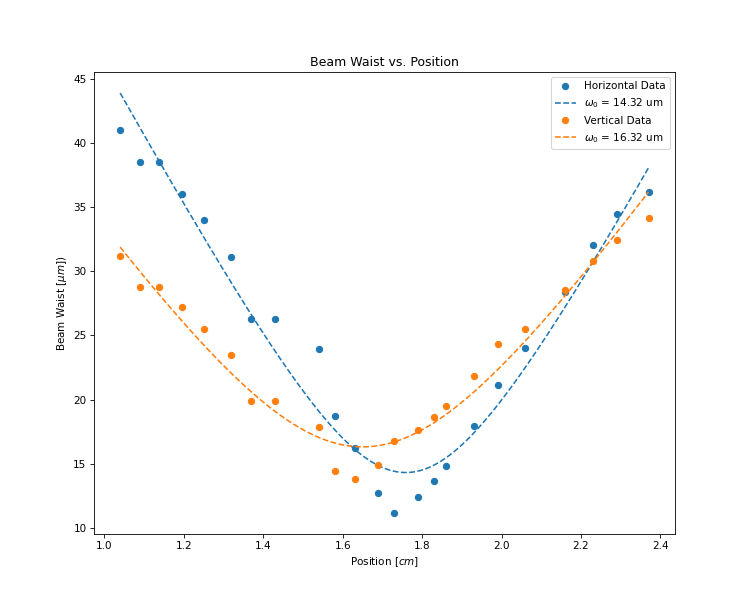

In [594]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
Horizontal Fit Results:
w0 (horizontal waist size)               = 14.318 um
M^2 (horizontal beam quality)            = 0.244
z0 (horizontal focus position)           = 17.588 mm

Vertical Fit Results:
w0 (vertical waist size)                 = 16.317 um
M^2 (vertical beam quality)              = 0.216
z0 (vertical focus position)             = 16.503 mm

Rayleigh length
z_R (rayleigh lenght)                    = 1.391 mm
# Define the beam propagation function for fitting
def beam_waist(z, w0, M2, z0, wavelength):
    return w0 * np.sqrt(1 + ((M2 * wavelength * (z - z0)) / (np.pi * w0**2))**2)

# Assuming all_fits is a 2D array where columns 3 and 4 correspond to arr_x and arr_y data

arr_x = np.array(all_fits).T[3] * 3.75e-6 # horizontal Gaussian widths (1D array)
arr_y = np.array(all_fits).T[4] * 3.75e-6 # vertical Gaussian widths (1D array)
wavelength = 1064e-9  # laser wavelength in meters

# Perform curve fitting for horizontal and vertical data separately
# Fit for horizontal data
popt_x, pcov_x = curve_fit(
    lambda z, w0, M2, z0: beam_waist(z, w0, M2, z0, wavelength), 
    d, arr_x, 
    p0=[0.000001, 1, d[np.argmin(arr_x)]], 
#     bounds=([0, 1, -np.inf], [np.inf, np.inf, np.inf]),  # Set M2 lower bound to 1
    maxfev=5000
)
w0_x, M2_x, z0_x = popt_x

# Fit for vertical data
popt_y, pcov_y = curve_fit(
    lambda z, w0, M2, z0: beam_waist(z, w0, M2, z0, wavelength), 
    d, arr_y, 
    p0=[0.000001, 1, d[np.argmin(arr_y)]], 
#     bounds=([0, 1, -np.inf], [np.inf, np.inf, np.inf]),  # Set M2 lower bound to 1
    maxfev=5000
)
w0_y, M2_y, z0_y = popt_y

rayleigh = np.pi*(w0_x**2 + w0_y**2)/wavelength

# Display the results
print("Horizontal Fit Results:")
print(f"{'w0 (horizontal waist size)':<40} = {round(w0_x*1e6, 3)} um")
print(f"{'M^2 (horizontal beam quality)':<40} = {round(M2_x, 3)}")
print(f"{'z0 (horizontal focus position)':<40} = {round(z0_x*1e3, 3)} mm")

print("\nVertical Fit Results:")
print(f"{'w0 (vertical waist size)':<40} = {round(w0_y*1e6, 3)} um")
print(f"{'M^2 (vertical beam quality)':<40} = {round(M2_y, 3)}")
print(f"{'z0 (vertical focus position)':<40} = {round(z0_y*1e3, 3)} mm")

print("\nRayleigh length")
print(f"{'z_R (rayleigh lenght)':<40} = {round(rayleigh*1000,3)} mm")
print()

# Plotting the results
z_fit = np.linspace(min(d), max(d), 500)
w_x_fit = beam_waist(z_fit, w0_x, M2_x, z0_x, wavelength)
w_y_fit = beam_waist(z_fit, w0_y, M2_y, z0_y, wavelength)

plt.figure(figsize=(10, 8))
plt.plot(d*100, arr_x*1e6, 'C0o', label="Horizontal Data")
plt.plot(z_fit*100, w_x_fit*1e6, 'C0--', label=fr"$\omega_0$ = {round(w0_x*1e6, 2)} um") #, M2 = {round(M2_x, 2)}, $\delta z$ = {round(100*z0_x, 2)} cm")
plt.plot(d*100, arr_y*1e6, 'C1o', label="Vertical Data")
plt.plot(z_fit*100, w_y_fit*1e6, 'C1--', label=fr"$\omega_0$ = {round(w0_y*1e6, 2)} um") #, M2 = {round(M2_y, 2)}, $\delta z$ = {round(100*z0_y, 2)} cm")
plt.xlabel("Position [$cm$]")
plt.ylabel("Beam Waist [$\mu m$])")
plt.legend()
plt.title("Beam Waist vs. Position")
plt.show()



## Wide Trap - take two - discrete steps

In [55]:
runs = [96, 97, 111, 99, 100, 101, 102, 107, 108]
scan_rngs = [0.1, 0.3, 0.5, 0.8, 1, 1.3, 1.5, 2, 2.5]
pics = [makeAPic(20250321, run, 0, multi_loop=0) for run in runs]
clear_output()

<IPython.core.display.Javascript object>


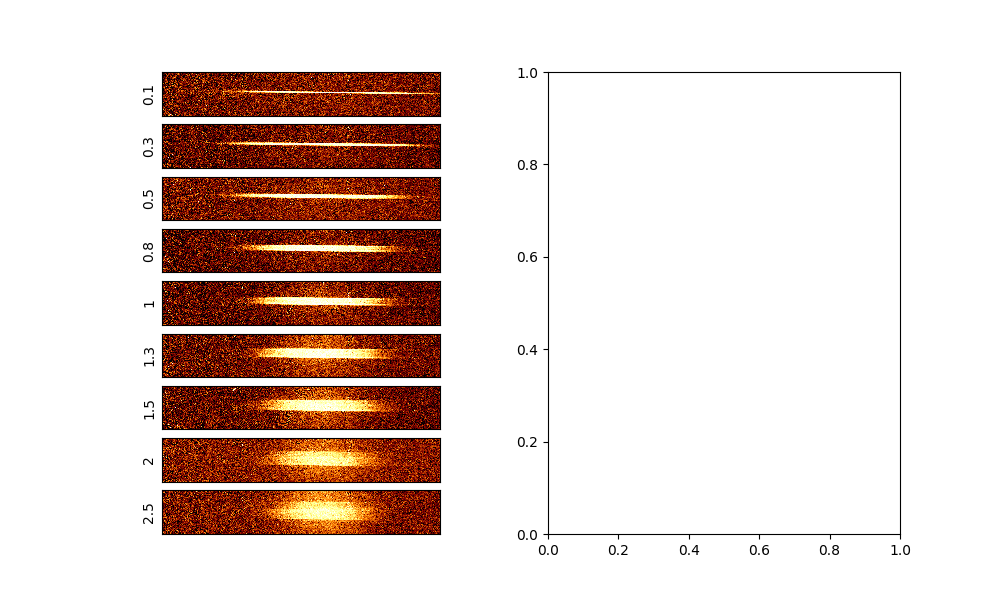

TypeError: linspace() missing 2 required positional arguments: 'start' and 'stop'

In [59]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(len(runs), 2)

# Create one subplot per row in the first column
axes_imgs = [fig.add_subplot(gs[i, 0]) for i in range(len(runs))]
for i, pic in enumerate(pics):
    axes_imgs[i].imshow(pic[900:1300], vmin=0, vmax=1.3, cmap="afmhot_r", interpolation='none')
    axes_imgs[i].set_xticks([])
    axes_imgs[i].set_yticks([])
    axes_imgs[i].set_ylabel(scan_rngs[i])
# Create one subplot spanning all rows in the second column
ax_plot = fig.add_subplot(gs[:, 1])
for i, pic in enumerate(pics):
    ax_plot.plot(np.linspace(-0.1, 0.1, 400), pic[900:1300, 1100:1800].mean(axis=1) - i * 0.3, alpha=0.3, label=scan_rngs[i])
    ax_plot.text(adasd)
# ax_plot.set_xticks([])
ax_plot.set_yticks([])
ax_plot.legend()
plt.tight_layout()
plt.show()
